In [4]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import os
import talos as ta
from talos.model.early_stopper import early_stopper
from sklearn.preprocessing import StandardScaler

%load_ext tensorboard
import tensorflow_addons as tfa
import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.metrics import Recall, Precision
import seaborn as sns

from sklearn.model_selection import train_test_split


import tensorflow as tf

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [5]:
train_df=pd.read_csv("D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/Dane_do_uczenia_T.csv", encoding="utf-8")
del train_df['Unnamed: 0']

In [6]:
train_df.head()

,ENSG00000168779.18,ENSG00000043355.9,ENSG00000139800.8,ENSG00000095752.5,ENSG00000114270.14,ENSG00000143320.7,ENSG00000104112.7,ENSG00000168703.5,ENSG00000116176.6,ENSG00000188523.7,...,ENSG00000104755.13,ENSG00000250256.1,ENSG00000259447.1,ENSG00000235864.1,ENSG00000227718.1,ENSG00000229370.1,ENSG00000254434.1,ENSG00000233146.1,ENSG00000251969.3,scale
0,6.418540,2.139513,2.139513,9.984396,139.068370,134.076172,11.410738,67.038086,173.300584,16.402936,...,0.000000,0.0,0.000000,0.00000,0.00000,0.0,1.426342,0.713171,0.000000,T1
1,4.254904,0.850981,0.000000,0.850981,45.101982,22.125501,84.247098,1.701962,11.913731,5.956866,...,0.850981,0.0,0.850981,0.00000,0.00000,0.0,0.000000,0.000000,0.000000,T1
2,1.931528,0.643843,0.000000,40.562078,452.621281,237.577884,6.438425,0.000000,16.096063,3.219213,...,0.000000,0.0,0.643843,0.00000,0.00000,0.0,0.000000,0.000000,0.000000,T1
3,0.870129,0.000000,0.000000,123.558325,773.544728,262.778974,15.662323,2.610387,70.480453,1.740258,...,0.000000,0.0,0.000000,0.00000,0.00000,0.0,0.000000,0.000000,0.870129,T1
4,2.718041,2.718041,2.718041,39.411591,145.415179,88.336324,19.026285,1167.398495,16.308244,16.308244,...,1.359020,0.0,1.359020,1.35902,1.35902,0.0,0.000000,0.000000,0.000000,T1


In [7]:
train_df['scale'].value_counts()

T1    496
T3    327
T2    132
Name: scale, dtype: int64

In [8]:
train_df['scale'].loc[(train_df['scale'] == 'T1')] = 0
train_df['scale'].loc[(train_df['scale'] == 'T2')] = 1
train_df['scale'].loc[(train_df['scale'] == 'T3')] = 2

In [9]:
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42,stratify=train_df['scale'])
#test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42,stratify=test_df['scale'])


train_label=train_df['scale']
test_label=test_df['scale']
#val_label=val_df['scale']
del train_df['scale']
del test_df['scale']
#del val_df['scale']


In [10]:
len(list(train_df))

105

In [11]:
train_label.shape

(764,)

In [12]:
test_label.shape

(191,)

In [13]:
#val_label.shape

## 1.2 Standaryzacja

In [14]:
scaler = StandardScaler()
train_df=scaler.fit_transform(train_df)
test_df=scaler.fit_transform(test_df)
#val_df=scaler.fit_transform(val_df)


In [15]:
train_df

array([[-0.03296043, -0.17404131, -0.22961697, ..., -0.18492773,
        -0.20587262, -0.13905207],
       [-0.09799013, -0.20838135, -0.22961697, ..., -0.18492773,
        -0.20587262, -0.13905207],
       [-0.08505218, -0.13459551,  0.03327218, ..., -0.12028205,
        -0.11752968, -0.13905207],
       ...,
       [-0.19643114, -0.1944861 , -0.22961697, ..., -0.18492773,
        -0.20587262, -0.13905207],
       [-0.17516001, -0.22062863, -0.22961697, ..., -0.18492773,
        -0.20587262, -0.13905207],
       [-0.00979766, -0.22062863, -0.22961697, ..., -0.18492773,
        -0.20587262, -0.13905207]])

In [16]:
train_df.shape

(764, 105)

In [17]:
train_label=np.asarray(train_label).astype(np.int)
test_label=np.asarray(test_label).astype(np.int)
#val_label=np.asarray(val_label).astype(np.int)

In [18]:
encoder = LabelEncoder()
encoder.fit(train_label)
train_label = encoder.transform(train_label)
# convert integers to dummy variables (i.e. one hot encoded)

train_label = np_utils.to_categorical(train_label)

In [19]:
encoder = LabelEncoder()
encoder.fit(test_label)
test_label = encoder.transform(test_label)
# convert integers to dummy variables (i.e. one hot encoded)

test_label = np_utils.to_categorical(test_label)

In [20]:
train_label

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [21]:
test_label

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0

In [22]:
train_label.shape

(764, 3)

In [23]:
train_label

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

# 2 Moduł TALOS

## 2.1 Słownik parametrów do wypróbowania

In [ ]:
## Dobor Gammy i alfy

In [33]:
p = {
    'first_neuron':[55,110,220], 
     'hidden_neuron':[50,100,150],

     'hidden_layers':[3,5,7,9,12],  

     
    'epochs': [100000], # never touch it


    'last_activation': ['softmax'], #never touch it


    'batch_size': [32],

    'lr':[0.001],
    
    'kernel_regularizer_l1':[0.0001],#[0,0.001,0.0001],
    'kernel_regularizer_l2':[0.0001],#[0,0.001,0.0001],
    'bias_regularizer':[0.0001],#[0,0.001,0.0001],
    'activity_regularizer':[0.0001],#[0,0.001,0.0001],

#    'batc_normalization':[False,True],
#    'dropout': [0,0.2,0.4],
    'dropout': [0],
    
    'optimizer': ['rmsprop','adam','adadelta','adamax','nadam','adagrad'],
#    'kernel_initializer': ['orthogonal','identity','zeros','ones','uniform'],
    'kernel_initializer': ['orthogonal'],
   # 'activation_layer':['sigmoid','tanh','selu','elu','relu'],
  #  'activation_layer':['relu'],
    'batc_normalization':[False,True]
 #   'batc_normalization':[False],

    
}

## 2.22 Weights for classes

In [34]:
# Calculate the weights for each class so that we can balance the data
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(train_label),
                                            y=train_label.ravel())

weights = array([0.64147775, 2.42539683, 0.97201018])

In [35]:

def numerai_model(x_train, y_train, x_val, y_val, params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(3, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=params['optimizer'],
                  #tf.keras.optimizers.Adamax(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=3,beta=1.0)])
    
  
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        class_weight={0 : 0.64147775,
                                      1 : 2.42539683,
                                      2 : 0.97201018},
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=1,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )

    return history, model

## 2.3 Przeprowadzam skan, używając parametrów i funkcji wyżej


##  3. Part 1

In [36]:

t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy T - Weighted binary cross-entropy (softmax)')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model weights from the end of the best epoch: 5.
Epoch 00055: early stopping


 95%|██████████████████████████████████████████████████████████████████████████▏   | 514/540 [2:27:35<08:33, 19.76s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object

 95%|██████████████████████████████████████████████████████████████████████████▍   | 515/540 [2:27:56<08:22, 20.08s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' obje

 96%|██████████████████████████████████████████████████████████████████████████▌   | 516/540 [2:28:11<07:22, 18.43s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' obje

 96%|██████████████████████████████████████████████████████████████████████████▋   | 517/540 [2:29:21<13:03, 34.08s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object 

 96%|██████████████████████████████████████████████████████████████████████████▊   | 518/540 [2:30:26<15:51, 43.27s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' obj

 96%|██████████████████████████████████████████████████████████████████████████▉   | 519/540 [2:30:43<12:24, 35.47s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' objec

 96%|███████████████████████████████████████████████████████████████████████████   | 520/540 [2:31:05<10:27, 31.37s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object

 96%|███████████████████████████████████████████████████████████████████████████▎  | 521/540 [2:32:28<14:49, 46.83s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 9, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' obje

 97%|███████████████████████████████████████████████████████████████████████████▍  | 522/540 [2:32:46<11:25, 38.11s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

 97%|███████████████████████████████████████████████████████████████████████████▌  | 523/540 [2:33:15<10:03, 35.51s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and at

 97%|███████████████████████████████████████████████████████████████████████████▋  | 524/540 [2:33:39<08:29, 31.82s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

 97%|███████████████████████████████████████████████████████████████████████████▊  | 525/540 [2:33:55<06:46, 27.09s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

 97%|███████████████████████████████████████████████████████████████████████████▉  | 526/540 [2:34:32<07:01, 30.09s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and a

 98%|████████████████████████████████████████████████████████████████████████████  | 527/540 [2:34:57<06:13, 28.75s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

 98%|████████████████████████████████████████████████████████████████████████████▎ | 528/540 [2:35:13<04:57, 24.81s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

 98%|████████████████████████████████████████████████████████████████████████████▍ | 529/540 [2:36:09<06:15, 34.17s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and a

 98%|████████████████████████████████████████████████████████████████████████████▌ | 530/540 [2:37:31<08:03, 48.39s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

 98%|████████████████████████████████████████████████████████████████████████████▋ | 531/540 [2:37:50<05:56, 39.58s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

 99%|████████████████████████████████████████████████████████████████████████████▊ | 532/540 [2:38:28<05:14, 39.32s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

 99%|████████████████████████████████████████████████████████████████████████████▉ | 533/540 [2:39:53<06:10, 52.90s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

 99%|█████████████████████████████████████████████████████████████████████████████▏| 534/540 [2:40:11<04:13, 42.33s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

 99%|█████████████████████████████████████████████████████████████████████████████▎| 535/540 [2:41:35<04:34, 54.93s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and a

 99%|█████████████████████████████████████████████████████████████████████████████▍| 536/540 [2:43:24<04:45, 71.31s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

 99%|█████████████████████████████████████████████████████████████████████████████▌| 537/540 [2:43:48<02:50, 56.89s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

100%|█████████████████████████████████████████████████████████████████████████████▋| 538/540 [2:44:36<01:48, 54.37s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

100%|█████████████████████████████████████████████████████████████████████████████▊| 539/540 [2:46:29<01:11, 71.99s/it]

{'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [2:46:51<00:00, 18.54s/it]


In [37]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/T/Predykcja klasy T - Weighted binary cross-entropy (softmax)/050922120301.csv')

In [38]:
df

,round_epochs,loss,fbeta_score,val_loss,val_fbeta_score,activity_regularizer,batc_normalization,batch_size,bias_regularizer,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr,optimizer
0,56,0.237748,[0.95345914 0.89285713 0.92730844],1.584663,[0.73732716 0.35714287 0.45871562],0.0001,False,32,0.0001,0,100000,55,3,50,orthogonal,0.0001,0.0001,softmax,0.001,rmsprop
1,55,0.222430,[0.9723618 0.93636364 0.9609375 ],1.654442,[0.69483566 0.25925925 0.45217392],0.0001,False,32,0.0001,0,100000,55,3,50,orthogonal,0.0001,0.0001,softmax,0.001,adam
2,51,0.861435,[0.00493827 0.24157955 0. ],0.881551,[0.01960784 0.24186045 0. ],0.0001,False,32,0.0001,0,100000,55,3,50,orthogonal,0.0001,0.0001,softmax,0.001,adadelta
3,62,0.383558,[0.8894536 0.7673469 0.8548387],0.975225,[0.75490195 0.35714287 0.59016395],0.0001,False,32,0.0001,0,100000,55,3,50,orthogonal,0.0001,0.0001,softmax,0.001,adamax
4,56,0.212719,[0.9708492 0.8849558 0.9551657],1.558193,[0.7272727 0.36065575 0.47524753],0.0001,False,32,0.0001,0,100000,55,3,50,orthogonal,0.0001,0.0001,softmax,0.001,nadam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,370,0.610296,[0.9236739 0.90990996 0.90431523],1.302908,[0.6934673 0.28571427 0.49253735],0.0001,True,32,0.0001,0,100000,220,12,150,orthogonal,0.0001,0.0001,softmax,0.001,adam
536,53,3.010354,[0.40305346 0.21203437 0.34351146],3.128910,[0.5116279 0.25 0.3508772],0.0001,True,32,0.0001,0,100000,220,12,150,orthogonal,0.0001,0.0001,softmax,0.001,adadelta
537,151,2.033046,[0.9321382 0.87826085 0.9168278 ],2.672759,[0.7853881 0.27272728 0.5546218 ],0.0001,True,32,0.0001,0,100000,220,12,150,orthogonal,0.0001,0.0001,softmax,0.001,adamax
538,305,0.709694,[0.9081501 0.84210527 0.8728652 ],1.335972,[0.6703297 0.26666668 0.51428574],0.0001,True,32,0.0001,0,100000,220,12,150,orthogonal,0.0001,0.0001,softmax,0.001,nadam


In [39]:
df=df.sort_values('val_loss',ascending=True)

In [40]:
df.columns

Index(['round_epochs', 'loss', 'fbeta_score', 'val_loss', 'val_fbeta_score',
       'activity_regularizer', 'batc_normalization', 'batch_size',
       'bias_regularizer', 'dropout', 'epochs', 'first_neuron',
       'hidden_layers', 'hidden_neuron', 'kernel_initializer',
       'kernel_regularizer_l1', 'kernel_regularizer_l2', 'last_activation',
       'lr', 'optimizer'],
      dtype='object')

In [41]:
df

,round_epochs,loss,fbeta_score,val_loss,val_fbeta_score,activity_regularizer,batc_normalization,batch_size,bias_regularizer,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr,optimizer
79,83,0.640290,[0.6403756 0. 0.17877094],0.638750,[0.6827586 0. 0. ],0.0001,False,32,0.0001,0,100000,55,12,100,orthogonal,0.0001,0.0001,softmax,0.001,adam
162,67,0.641137,[0.42917252 0.16603774 0.31636366],0.638828,[0.6827586 0. 0. ],0.0001,False,32,0.0001,0,100000,110,12,50,orthogonal,0.0001,0.0001,softmax,0.001,rmsprop
163,86,0.639362,[0.18661258 0.20654045 0.2290749 ],0.639512,[0. 0.24770641 0. ],0.0001,False,32,0.0001,0,100000,110,12,50,orthogonal,0.0001,0.0001,softmax,0.001,adam
169,107,0.639984,[0.6838932 0. 0. ],0.639708,[0.6827586 0. 0. ],0.0001,False,32,0.0001,0,100000,110,12,100,orthogonal,0.0001,0.0001,softmax,0.001,adam
259,76,0.640387,[0.13129103 0.12075472 0.46401986],0.640078,[0.6827586 0. 0. ],0.0001,False,32,0.0001,0,100000,220,12,100,orthogonal,0.0001,0.0001,softmax,0.001,adam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,51,2.752526,[0.5534407 0.27906978 0.45109782],2.812747,[0.5842697 0.26966292 0.38260868],0.0001,True,32,0.0001,0,100000,110,12,150,orthogonal,0.0001,0.0001,softmax,0.001,adagrad
356,51,2.762955,[0.40364188 0.23163842 0.3339806 ],2.856422,[0.23611109 0.16494846 0.35460994],0.0001,True,32,0.0001,0,100000,55,12,150,orthogonal,0.0001,0.0001,softmax,0.001,adadelta
446,51,2.907009,[0.39502332 0.18994415 0.31878555],2.956668,[0.25 0.22222221 0.40000004],0.0001,True,32,0.0001,0,100000,110,12,150,orthogonal,0.0001,0.0001,softmax,0.001,adadelta
539,51,2.884065,[0.4977645 0.2793296 0.4248497],2.965478,[0.5368421 0.22535212 0.36363637],0.0001,True,32,0.0001,0,100000,220,12,150,orthogonal,0.0001,0.0001,softmax,0.001,adagrad


Text(0.5, 1.0, 'Validation Loss as function of first_neuron')

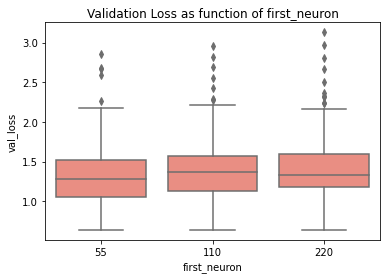

In [42]:
metric = 'first_neuron'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


Text(0.5, 1.0, 'Validation Loss as function of hidden_neuron')

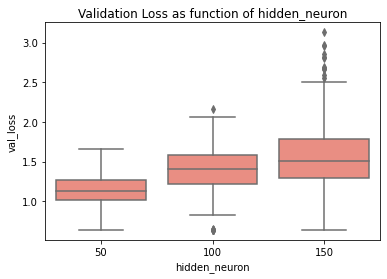

In [43]:
metric = 'hidden_neuron'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


Text(0.5, 1.0, 'Validation Loss as function of hidden_layers')

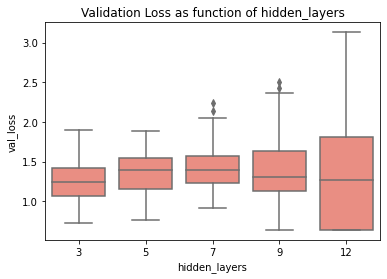

In [44]:
metric = 'hidden_layers'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


Text(0.5, 1.0, 'Validation Loss as function of optimizer')

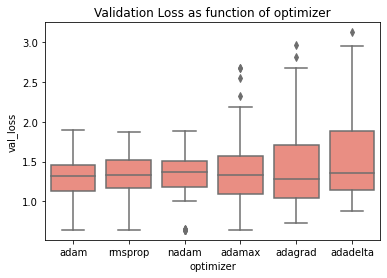

In [45]:
metric = 'optimizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


Text(0.5, 1.0, 'Validation Loss as function of batc_normalization')

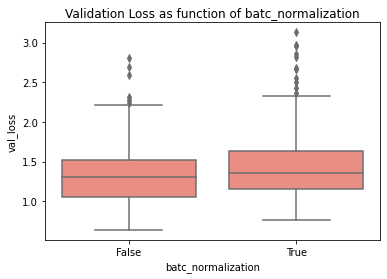

In [46]:
metric = 'batc_normalization'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


## Part 2

In [47]:

def numerai_model(x_train, y_train, x_val, y_val, params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(3, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adagrad(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=3,beta=1.0)])
    
  
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        class_weight={0 : 0.64147775,
                                      1 : 2.42539683,
                                      2 : 0.97201018},
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=1,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )

    return history, model

In [55]:
p = {
    'first_neuron':[55,330,440], 
     'hidden_neuron':[50,100,150],

     'hidden_layers':[1,3,6,12],  

     
    'epochs': [100000], # never touch it


    'last_activation': ['softmax'], #never touch it


    'batch_size': [32],

    'lr':[0.001],
    
    'kernel_regularizer_l1':[0.0001],#[0,0.001,0.0001],
    'kernel_regularizer_l2':[0.0001],#[0,0.001,0.0001],
    'bias_regularizer':[0.0001],#[0,0.001,0.0001],
    'activity_regularizer':[0.0001],#[0,0.001,0.0001],

#    'batc_normalization':[False,True],
#    'dropout': [0,0.2,0.4],
    'dropout': [0],
    
  #  'kernel_initializer': ['orthogonal','identity','zeros','ones','uniform'],
'kernel_initializer': ['orthogonal'],
   
    'activation_layer':['sigmoid','tanh','selu','elu','relu'],
  #  'activation_layer':['relu'],
    'batc_normalization':[False,True]
 #   'batc_normalization':[False],

    
}

In [56]:

t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy T - Weighted binary cross-entropy (softmax)')

Restoring model weights from the end of the best epoch: 2083.
Epoch 02133: early stopping


 30%|██████████████████████▏                                                   | 108/360 [1:35:13<11:32:47, 164.95s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_no

 30%|██████████████████████▋                                                    | 109/360 [1:35:25<8:18:41, 119.21s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 31%|███████████████████████▏                                                    | 110/360 [1:35:40<6:06:06, 87.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 31%|███████████████████████▍                                                    | 111/360 [1:35:54<4:32:52, 65.75s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t

 31%|███████████████████████▋                                                    | 112/360 [1:36:01<3:19:14, 48.20s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 31%|███████████████████████▊                                                    | 113/360 [1:36:17<2:37:55, 38.36s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 32%|████████████████████████                                                    | 114/360 [1:36:38<2:16:27, 33.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc

 32%|████████████████████████▎                                                   | 115/360 [1:36:48<1:47:23, 26.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 32%|████████████████████████▍                                                   | 116/360 [1:37:00<1:29:07, 21.91s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 32%|████████████████████████▋                                                   | 117/360 [1:37:13<1:17:53, 19.23s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

 33%|████████████████████████▉                                                   | 118/360 [1:37:28<1:12:26, 17.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 33%|█████████████████████████                                                   | 119/360 [1:37:45<1:11:00, 17.68s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 33%|█████████████████████████▎                                                  | 120/360 [1:38:06<1:15:04, 18.77s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 34%|█████████████████████████▌                                                  | 121/360 [1:38:24<1:14:00, 18.58s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 34%|█████████████████████████▊                                                  | 122/360 [1:38:47<1:19:00, 19.92s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 34%|█████████████████████████▉                                                  | 123/360 [1:39:04<1:15:08, 19.02s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 34%|██████████████████████████▏                                                 | 124/360 [1:39:19<1:09:41, 17.72s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 35%|██████████████████████████▍                                                 | 125/360 [1:39:42<1:16:09, 19.45s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 35%|██████████████████████████▌                                                 | 126/360 [1:40:12<1:27:33, 22.45s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 35%|██████████████████████████▊                                                 | 127/360 [1:40:23<1:13:58, 19.05s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 36%|███████████████████████████                                                 | 128/360 [1:40:58<1:31:58, 23.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 36%|███████████████████████████▏                                                | 129/360 [1:41:13<1:21:17, 21.12s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 36%|███████████████████████████▍                                                | 130/360 [1:41:30<1:16:52, 20.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 36%|███████████████████████████▋                                                | 131/360 [1:41:50<1:15:54, 19.89s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 37%|███████████████████████████▊                                                | 132/360 [1:42:13<1:19:24, 20.90s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 37%|████████████████████████████                                                | 133/360 [1:42:25<1:08:39, 18.15s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 37%|████████████████████████████▎                                               | 134/360 [1:42:42<1:07:44, 17.98s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 38%|████████████████████████████▌                                               | 135/360 [1:43:03<1:09:58, 18.66s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 38%|████████████████████████████▋                                               | 136/360 [1:43:23<1:11:11, 19.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 38%|████████████████████████████▉                                               | 137/360 [1:43:44<1:13:52, 19.88s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 38%|█████████████████████████████▏                                              | 138/360 [1:44:03<1:12:07, 19.49s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 39%|█████████████████████████████▎                                              | 139/360 [1:44:13<1:01:00, 16.56s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 39%|██████████████████████████████▎                                               | 140/360 [1:44:24<54:52, 14.97s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 39%|██████████████████████████████▌                                               | 141/360 [1:44:37<52:41, 14.44s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 39%|██████████████████████████████▊                                               | 142/360 [1:44:52<52:43, 14.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 40%|██████████████████████████████▉                                               | 143/360 [1:45:09<55:53, 15.45s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 40%|██████████████████████████████▍                                             | 144/360 [1:45:29<1:00:35, 16.83s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 40%|███████████████████████████████▍                                              | 145/360 [1:45:42<55:58, 15.62s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 41%|███████████████████████████████▋                                              | 146/360 [1:45:58<55:55, 15.68s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 41%|███████████████████████████████▊                                              | 147/360 [1:46:18<59:45, 16.83s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 41%|███████████████████████████████▏                                            | 148/360 [1:46:42<1:07:01, 18.97s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 41%|███████████████████████████████▍                                            | 149/360 [1:47:06<1:12:11, 20.53s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 42%|███████████████████████████████▋                                            | 150/360 [1:47:37<1:23:37, 23.89s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 42%|███████████████████████████████▉                                            | 151/360 [1:47:48<1:09:17, 19.89s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 42%|████████████████████████████████                                            | 152/360 [1:48:03<1:03:44, 18.39s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 42%|████████████████████████████████▎                                           | 153/360 [1:49:04<1:47:11, 31.07s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 43%|████████████████████████████████▌                                           | 154/360 [1:49:21<1:32:25, 26.92s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 43%|████████████████████████████████▋                                           | 155/360 [1:49:51<1:35:49, 28.04s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 43%|████████████████████████████████▌                                          | 156/360 [1:54:48<6:09:03, 108.54s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 44%|█████████████████████████████████▏                                          | 157/360 [1:55:05<4:34:43, 81.20s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do

 44%|█████████████████████████████████▎                                          | 158/360 [1:55:27<3:33:04, 63.29s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do

 44%|█████████████████████████████████▌                                          | 159/360 [1:55:48<2:49:32, 50.61s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 44%|█████████████████████████████████▊                                          | 160/360 [1:56:10<2:19:56, 41.98s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with

 45%|█████████████████████████████████▉                                          | 161/360 [1:56:39<2:06:13, 38.06s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with

 45%|██████████████████████████████████▏                                         | 162/360 [1:57:15<2:03:55, 37.55s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 45%|██████████████████████████████████▍                                         | 163/360 [1:57:29<1:40:22, 30.57s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil

 46%|██████████████████████████████████▌                                         | 164/360 [1:57:45<1:25:36, 26.21s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil

 46%|██████████████████████████████████▊                                         | 165/360 [1:58:56<2:09:09, 39.74s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 46%|███████████████████████████████████                                         | 166/360 [1:59:21<1:53:55, 35.23s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

 46%|███████████████████████████████████▎                                        | 167/360 [1:59:57<1:53:30, 35.29s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

 47%|███████████████████████████████████                                        | 168/360 [2:08:10<9:12:33, 172.68s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 47%|███████████████████████████████████▏                                       | 169/360 [2:08:27<6:41:16, 126.06s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do

 47%|███████████████████████████████████▉                                        | 170/360 [2:08:47<4:58:05, 94.13s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do

 48%|████████████████████████████████████                                        | 171/360 [2:09:08<3:47:46, 72.31s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 48%|████████████████████████████████████▎                                       | 172/360 [2:09:34<3:02:31, 58.25s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with

 48%|████████████████████████████████████▌                                       | 173/360 [2:10:04<2:35:12, 49.80s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with

 48%|████████████████████████████████████▋                                       | 174/360 [2:10:40<2:21:21, 45.60s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 49%|████████████████████████████████████▉                                       | 175/360 [2:10:54<1:51:56, 36.30s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil

 49%|█████████████████████████████████████▏                                      | 176/360 [2:11:10<1:32:16, 30.09s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil

 49%|█████████████████████████████████████▎                                      | 177/360 [2:12:16<2:05:15, 41.07s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 49%|█████████████████████████████████████▌                                      | 178/360 [2:12:37<1:45:46, 34.87s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

 50%|█████████████████████████████████████▊                                      | 179/360 [2:13:07<1:41:15, 33.57s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

 50%|█████████████████████████████████████▌                                     | 180/360 [2:18:34<6:04:16, 121.42s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_no

 50%|██████████████████████████████████████▏                                     | 181/360 [2:18:47<4:25:45, 89.08s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 51%|██████████████████████████████████████▍                                     | 182/360 [2:19:00<3:16:00, 66.07s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 51%|██████████████████████████████████████▋                                     | 183/360 [2:19:10<2:25:38, 49.37s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t

 51%|██████████████████████████████████████▊                                     | 184/360 [2:19:25<1:54:38, 39.08s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 51%|███████████████████████████████████████                                     | 185/360 [2:19:39<1:31:46, 31.47s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 52%|███████████████████████████████████████▎                                    | 186/360 [2:19:46<1:09:55, 24.11s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc

 52%|████████████████████████████████████████▌                                     | 187/360 [2:19:54<55:42, 19.32s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 52%|███████████████████████████████████████▋                                    | 188/360 [2:20:26<1:06:31, 23.20s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 52%|███████████████████████████████████████▉                                    | 189/360 [2:20:43<1:00:46, 21.33s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

 53%|█████████████████████████████████████████▏                                    | 190/360 [2:20:59<55:18, 19.52s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 53%|█████████████████████████████████████████▍                                    | 191/360 [2:21:16<53:06, 18.86s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 53%|█████████████████████████████████████████▌                                    | 192/360 [2:21:38<55:09, 19.70s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 54%|█████████████████████████████████████████▊                                    | 193/360 [2:21:56<54:02, 19.42s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 54%|██████████████████████████████████████████                                    | 194/360 [2:22:22<58:53, 21.28s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 54%|█████████████████████████████████████████▏                                  | 195/360 [2:22:46<1:00:59, 22.18s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 54%|█████████████████████████████████████████▍                                  | 196/360 [2:23:27<1:16:07, 27.85s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 55%|█████████████████████████████████████████▌                                  | 197/360 [2:23:39<1:02:18, 22.94s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 55%|█████████████████████████████████████████▊                                  | 198/360 [2:24:18<1:14:57, 27.76s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 55%|██████████████████████████████████████████                                  | 199/360 [2:24:31<1:02:28, 23.28s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 56%|███████████████████████████████████████████▎                                  | 200/360 [2:24:45<54:41, 20.51s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 56%|███████████████████████████████████████████▌                                  | 201/360 [2:25:02<52:13, 19.71s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 56%|███████████████████████████████████████████▊                                  | 202/360 [2:25:19<49:14, 18.70s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 56%|███████████████████████████████████████████▉                                  | 203/360 [2:25:37<48:50, 18.66s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 57%|████████████████████████████████████████████▏                                 | 204/360 [2:26:02<53:07, 20.43s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 57%|████████████████████████████████████████████▍                                 | 205/360 [2:26:21<51:25, 19.91s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 57%|████████████████████████████████████████████▋                                 | 206/360 [2:26:36<47:29, 18.51s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 57%|████████████████████████████████████████████▊                                 | 207/360 [2:26:48<42:08, 16.52s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 58%|█████████████████████████████████████████████                                 | 208/360 [2:27:04<41:32, 16.40s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 58%|█████████████████████████████████████████████▎                                | 209/360 [2:27:20<40:49, 16.22s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 58%|█████████████████████████████████████████████▌                                | 210/360 [2:27:28<34:53, 13.96s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 59%|█████████████████████████████████████████████▋                                | 211/360 [2:27:52<41:49, 16.84s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 59%|█████████████████████████████████████████████▉                                | 212/360 [2:28:02<36:22, 14.74s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 59%|██████████████████████████████████████████████▏                               | 213/360 [2:28:14<34:24, 14.04s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 59%|██████████████████████████████████████████████▎                               | 214/360 [2:28:26<32:52, 13.51s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 60%|██████████████████████████████████████████████▌                               | 215/360 [2:28:41<33:08, 13.71s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 60%|██████████████████████████████████████████████▊                               | 216/360 [2:28:58<35:25, 14.76s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_no

 60%|███████████████████████████████████████████████                               | 217/360 [2:29:10<33:18, 13.98s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 61%|███████████████████████████████████████████████▏                              | 218/360 [2:29:25<33:46, 14.27s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 61%|███████████████████████████████████████████████▍                              | 219/360 [2:29:41<34:34, 14.71s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t

 61%|███████████████████████████████████████████████▋                              | 220/360 [2:30:02<38:55, 16.68s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 61%|███████████████████████████████████████████████▉                              | 221/360 [2:30:23<41:30, 17.92s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 62%|████████████████████████████████████████████████                              | 222/360 [2:30:50<47:49, 20.80s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc

 62%|████████████████████████████████████████████████▎                             | 223/360 [2:30:58<38:24, 16.82s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 62%|████████████████████████████████████████████████▌                             | 224/360 [2:31:11<35:27, 15.64s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 62%|████████████████████████████████████████████████▊                             | 225/360 [2:31:56<54:51, 24.38s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

 63%|████████████████████████████████████████████████▉                             | 226/360 [2:32:11<48:24, 21.67s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 63%|█████████████████████████████████████████████████▏                            | 227/360 [2:32:31<46:47, 21.11s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 63%|████████████████████████████████████████████████▏                           | 228/360 [2:34:54<2:07:07, 57.79s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 64%|████████████████████████████████████████████████▎                           | 229/360 [2:35:10<1:38:33, 45.14s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 64%|████████████████████████████████████████████████▌                           | 230/360 [2:35:28<1:20:08, 36.99s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 64%|████████████████████████████████████████████████▊                           | 231/360 [2:35:48<1:08:50, 32.02s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 64%|████████████████████████████████████████████████▉                           | 232/360 [2:36:13<1:03:36, 29.82s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 65%|█████████████████████████████████████████████████▏                          | 233/360 [2:36:40<1:01:31, 29.07s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 65%|█████████████████████████████████████████████████▍                          | 234/360 [2:37:08<1:00:33, 28.84s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 65%|██████████████████████████████████████████████████▉                           | 235/360 [2:37:22<50:16, 24.14s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 66%|█████████████████████████████████████████████████▊                          | 236/360 [2:38:05<1:02:11, 30.09s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 66%|██████████████████████████████████████████████████                          | 237/360 [2:39:00<1:16:56, 37.53s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 66%|██████████████████████████████████████████████████▏                         | 238/360 [2:39:22<1:06:24, 32.66s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 66%|██████████████████████████████████████████████████▍                         | 239/360 [2:39:57<1:07:23, 33.42s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 67%|██████████████████████████████████████████████████                         | 240/360 [2:45:55<4:21:29, 130.74s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 67%|██████████████████████████████████████████████████▉                         | 241/360 [2:46:13<3:12:15, 96.94s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 67%|███████████████████████████████████████████████████                         | 242/360 [2:46:32<2:24:47, 73.62s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 68%|███████████████████████████████████████████████████▎                        | 243/360 [2:46:52<1:51:59, 57.44s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 68%|███████████████████████████████████████████████████▌                        | 244/360 [2:47:17<1:32:23, 47.79s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 68%|███████████████████████████████████████████████████▋                        | 245/360 [2:47:46<1:20:44, 42.13s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 68%|███████████████████████████████████████████████████▉                        | 246/360 [2:48:20<1:15:23, 39.68s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 69%|████████████████████████████████████████████████████▏                       | 247/360 [2:48:58<1:14:05, 39.34s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 69%|████████████████████████████████████████████████████▎                       | 248/360 [2:49:37<1:13:07, 39.17s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 69%|████████████████████████████████████████████████████▌                       | 249/360 [2:50:34<1:22:06, 44.38s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 69%|████████████████████████████████████████████████████▊                       | 250/360 [2:50:57<1:09:38, 37.98s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 70%|████████████████████████████████████████████████████▉                       | 251/360 [2:51:36<1:09:37, 38.32s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 70%|████████████████████████████████████████████████████▌                      | 252/360 [3:03:10<7:03:17, 235.16s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not

 70%|████████████████████████████████████████████████████▋                      | 253/360 [3:03:24<5:00:50, 168.70s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_no

 71%|████████████████████████████████████████████████████▉                      | 254/360 [3:03:36<3:34:51, 121.62s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_no

 71%|█████████████████████████████████████████████████████▊                      | 255/360 [3:03:47<2:34:51, 88.49s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf

 71%|██████████████████████████████████████████████████████                      | 256/360 [3:03:53<1:50:22, 63.68s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t

 71%|██████████████████████████████████████████████████████▎                     | 257/360 [3:04:10<1:25:34, 49.85s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t

 72%|██████████████████████████████████████████████████████▍                     | 258/360 [3:04:17<1:02:47, 36.94s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence

 72%|████████████████████████████████████████████████████████                      | 259/360 [3:04:25<47:23, 28.15s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc

 72%|████████████████████████████████████████████████████████▎                     | 260/360 [3:04:33<36:56, 22.17s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc

 72%|████████████████████████████████████████████████████████▌                     | 261/360 [3:04:43<30:22, 18.41s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

 73%|████████████████████████████████████████████████████████▊                     | 262/360 [3:04:54<26:42, 16.35s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

 73%|████████████████████████████████████████████████████████▉                     | 263/360 [3:05:07<24:55, 15.41s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

 73%|█████████████████████████████████████████████████████████▏                    | 264/360 [3:05:24<25:04, 15.67s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_no

 74%|█████████████████████████████████████████████████████████▍                    | 265/360 [3:05:34<22:28, 14.20s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 74%|█████████████████████████████████████████████████████████▋                    | 266/360 [3:05:46<20:59, 13.40s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 74%|█████████████████████████████████████████████████████████▊                    | 267/360 [3:05:57<19:51, 12.81s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t

 74%|██████████████████████████████████████████████████████████                    | 268/360 [3:06:13<20:53, 13.62s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 75%|██████████████████████████████████████████████████████████▎                   | 269/360 [3:06:25<19:49, 13.07s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 75%|██████████████████████████████████████████████████████████▌                   | 270/360 [3:06:41<20:53, 13.93s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc

 75%|██████████████████████████████████████████████████████████▋                   | 271/360 [3:06:49<18:25, 12.42s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 76%|██████████████████████████████████████████████████████████▉                   | 272/360 [3:07:11<22:11, 15.14s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 76%|███████████████████████████████████████████████████████████▏                  | 273/360 [3:07:22<20:02, 13.82s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

 76%|███████████████████████████████████████████████████████████▎                  | 274/360 [3:07:34<19:13, 13.41s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 76%|███████████████████████████████████████████████████████████▌                  | 275/360 [3:07:48<19:23, 13.69s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 77%|███████████████████████████████████████████████████████████▊                  | 276/360 [3:08:06<20:35, 14.71s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_no

 77%|████████████████████████████████████████████████████████████                  | 277/360 [3:08:17<19:01, 13.76s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 77%|████████████████████████████████████████████████████████████▏                 | 278/360 [3:08:30<18:22, 13.44s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 78%|████████████████████████████████████████████████████████████▍                 | 279/360 [3:08:47<19:42, 14.60s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t

 78%|████████████████████████████████████████████████████████████▋                 | 280/360 [3:08:54<16:17, 12.22s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 78%|████████████████████████████████████████████████████████████▉                 | 281/360 [3:09:13<18:41, 14.20s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 78%|█████████████████████████████████████████████████████████████                 | 282/360 [3:09:29<19:15, 14.82s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc

 79%|█████████████████████████████████████████████████████████████▎                | 283/360 [3:09:50<21:35, 16.82s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 79%|█████████████████████████████████████████████████████████████▌                | 284/360 [3:10:13<23:41, 18.71s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 79%|█████████████████████████████████████████████████████████████▊                | 285/360 [3:10:25<20:48, 16.65s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

 79%|█████████████████████████████████████████████████████████████▉                | 286/360 [3:10:38<19:05, 15.47s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 80%|██████████████████████████████████████████████████████████████▏               | 287/360 [3:10:53<18:30, 15.21s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 80%|██████████████████████████████████████████████████████████████▍               | 288/360 [3:11:10<19:02, 15.87s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 80%|██████████████████████████████████████████████████████████████▌               | 289/360 [3:11:23<17:34, 14.85s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 81%|██████████████████████████████████████████████████████████████▊               | 290/360 [3:11:36<16:59, 14.56s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 81%|███████████████████████████████████████████████████████████████               | 291/360 [3:11:51<16:37, 14.46s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 81%|███████████████████████████████████████████████████████████████▎              | 292/360 [3:12:08<17:14, 15.21s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 81%|███████████████████████████████████████████████████████████████▍              | 293/360 [3:12:28<18:35, 16.65s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 82%|███████████████████████████████████████████████████████████████▋              | 294/360 [3:12:53<21:10, 19.25s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 82%|███████████████████████████████████████████████████████████████▉              | 295/360 [3:13:04<18:02, 16.66s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 82%|████████████████████████████████████████████████████████████████▏             | 296/360 [3:13:13<15:33, 14.58s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 82%|████████████████████████████████████████████████████████████████▎             | 297/360 [3:13:26<14:43, 14.02s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 83%|████████████████████████████████████████████████████████████████▌             | 298/360 [3:13:41<14:55, 14.45s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 83%|████████████████████████████████████████████████████████████████▊             | 299/360 [3:14:01<16:19, 16.06s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 83%|██████████████████████████████████████████████████████████████▌            | 300/360 [3:20:03<1:59:49, 119.83s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 84%|███████████████████████████████████████████████████████████████▌            | 301/360 [3:20:22<1:28:02, 89.54s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do

 84%|███████████████████████████████████████████████████████████████▊            | 302/360 [3:20:40<1:05:55, 68.19s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do

 84%|█████████████████████████████████████████████████████████████████▋            | 303/360 [3:20:58<50:21, 53.00s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 84%|█████████████████████████████████████████████████████████████████▊            | 304/360 [3:21:22<41:18, 44.25s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with

 85%|██████████████████████████████████████████████████████████████████            | 305/360 [3:21:47<35:24, 38.62s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with

 85%|██████████████████████████████████████████████████████████████████▎           | 306/360 [3:22:18<32:30, 36.13s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 85%|██████████████████████████████████████████████████████████████████▌           | 307/360 [3:22:31<25:47, 29.20s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil

 86%|██████████████████████████████████████████████████████████████████▋           | 308/360 [3:22:45<21:33, 24.87s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil

 86%|██████████████████████████████████████████████████████████████████▉           | 309/360 [3:23:38<28:04, 33.03s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 86%|███████████████████████████████████████████████████████████████████▏          | 310/360 [3:23:56<23:48, 28.57s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

 86%|███████████████████████████████████████████████████████████████████▍          | 311/360 [3:24:28<24:21, 29.82s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

 87%|█████████████████████████████████████████████████████████████████▊          | 312/360 [3:28:04<1:08:30, 85.64s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 87%|███████████████████████████████████████████████████████████████████▊          | 313/360 [3:28:22<51:09, 65.31s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do

 87%|████████████████████████████████████████████████████████████████████          | 314/360 [3:28:40<39:10, 51.10s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do

 88%|████████████████████████████████████████████████████████████████████▎         | 315/360 [3:29:01<31:33, 42.07s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 88%|████████████████████████████████████████████████████████████████████▍         | 316/360 [3:29:25<26:47, 36.54s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with

 88%|████████████████████████████████████████████████████████████████████▋         | 317/360 [3:29:55<24:48, 34.62s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with

 88%|████████████████████████████████████████████████████████████████████▉         | 318/360 [3:30:29<24:14, 34.62s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 89%|█████████████████████████████████████████████████████████████████████         | 319/360 [3:30:45<19:43, 28.87s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil

 89%|█████████████████████████████████████████████████████████████████████▎        | 320/360 [3:31:31<22:42, 34.05s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil

 89%|█████████████████████████████████████████████████████████████████████▌        | 321/360 [3:32:30<26:55, 41.42s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 89%|█████████████████████████████████████████████████████████████████████▊        | 322/360 [3:32:52<22:32, 35.59s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

 90%|█████████████████████████████████████████████████████████████████████▉        | 323/360 [3:33:25<21:29, 34.86s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

 90%|███████████████████████████████████████████████████████████████████▌       | 324/360 [3:37:51<1:02:33, 104.27s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_no

 90%|██████████████████████████████████████████████████████████████████████▍       | 325/360 [3:38:05<44:57, 77.08s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 91%|██████████████████████████████████████████████████████████████████████▋       | 326/360 [3:38:18<32:52, 58.01s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 91%|██████████████████████████████████████████████████████████████████████▊       | 327/360 [3:38:29<24:06, 43.84s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t

 91%|███████████████████████████████████████████████████████████████████████       | 328/360 [3:38:42<18:25, 34.54s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 91%|███████████████████████████████████████████████████████████████████████▎      | 329/360 [3:38:55<14:33, 28.17s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 92%|███████████████████████████████████████████████████████████████████████▌      | 330/360 [3:39:15<12:54, 25.81s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc

 92%|███████████████████████████████████████████████████████████████████████▋      | 331/360 [3:39:23<09:49, 20.33s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 92%|███████████████████████████████████████████████████████████████████████▉      | 332/360 [3:39:31<07:49, 16.76s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 92%|████████████████████████████████████████████████████████████████████████▏     | 333/360 [3:39:41<06:34, 14.62s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

 93%|████████████████████████████████████████████████████████████████████████▎     | 334/360 [3:39:52<05:55, 13.67s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 93%|████████████████████████████████████████████████████████████████████████▌     | 335/360 [3:40:05<05:36, 13.46s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 93%|████████████████████████████████████████████████████████████████████████▊     | 336/360 [3:40:22<05:43, 14.32s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 94%|█████████████████████████████████████████████████████████████████████████     | 337/360 [3:40:37<05:35, 14.59s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 94%|█████████████████████████████████████████████████████████████████████████▏    | 338/360 [3:40:52<05:22, 14.66s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 94%|█████████████████████████████████████████████████████████████████████████▍    | 339/360 [3:41:07<05:13, 14.92s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 94%|█████████████████████████████████████████████████████████████████████████▋    | 340/360 [3:41:24<05:06, 15.32s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 95%|█████████████████████████████████████████████████████████████████████████▉    | 341/360 [3:41:36<04:33, 14.40s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 95%|██████████████████████████████████████████████████████████████████████████    | 342/360 [3:41:54<04:41, 15.63s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 95%|██████████████████████████████████████████████████████████████████████████▎   | 343/360 [3:42:03<03:49, 13.53s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 96%|██████████████████████████████████████████████████████████████████████████▌   | 344/360 [3:42:24<04:12, 15.75s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 96%|██████████████████████████████████████████████████████████████████████████▊   | 345/360 [3:42:35<03:37, 14.49s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 96%|██████████████████████████████████████████████████████████████████████████▉   | 346/360 [3:42:48<03:13, 13.81s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 96%|███████████████████████████████████████████████████████████████████████████▏  | 347/360 [3:43:02<03:01, 13.99s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 330, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

 97%|███████████████████████████████████████████████████████████████████████████▍  | 348/360 [3:43:19<02:59, 14.95s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 97%|███████████████████████████████████████████████████████████████████████████▌  | 349/360 [3:43:33<02:41, 14.72s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 97%|███████████████████████████████████████████████████████████████████████████▊  | 350/360 [3:43:46<02:20, 14.01s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 1, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 98%|████████████████████████████████████████████████████████████████████████████  | 351/360 [3:44:01<02:09, 14.41s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 98%|████████████████████████████████████████████████████████████████████████████▎ | 352/360 [3:44:15<01:54, 14.33s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 98%|████████████████████████████████████████████████████████████████████████████▍ | 353/360 [3:44:26<01:33, 13.37s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 3, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 98%|████████████████████████████████████████████████████████████████████████████▋ | 354/360 [3:44:44<01:27, 14.56s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen

 99%|████████████████████████████████████████████████████████████████████████████▉ | 355/360 [3:44:53<01:04, 12.87s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 99%|█████████████████████████████████████████████████████████████████████████████▏| 356/360 [3:45:19<01:07, 16.85s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 6, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

 99%|█████████████████████████████████████████████████████████████████████████████▎| 357/360 [3:45:30<00:45, 15.27s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

 99%|█████████████████████████████████████████████████████████████████████████████▌| 358/360 [3:45:43<00:29, 14.55s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

100%|█████████████████████████████████████████████████████████████████████████████▊| 359/360 [3:45:58<00:14, 14.58s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 440, 'hidden_layers': 12, 'hidden_neuron': 150, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'softmax', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
adding layer 8
adding layer 9
adding layer 10
adding layer 11
adding layer 12
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

100%|██████████████████████████████████████████████████████████████████████████████| 360/360 [3:46:15<00:00, 37.71s/it]


In [57]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/T/Predykcja klasy T - Weighted binary cross-entropy (softmax)/050922154138.csv')

In [58]:
df=df.sort_values('val_loss',ascending=True)

In [59]:
df

,round_epochs,loss,fbeta_score,val_loss,val_fbeta_score,activation_layer,activity_regularizer,batc_normalization,batch_size,bias_regularizer,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
0,249,0.646124,[0.74712646 0.3800905 0.55835235],0.647863,[0.7699531 0.36923078 0.4230769 ],sigmoid,0.0001,False,32,0.0001,0,100000,55,1,50,orthogonal,0.0001,0.0001,softmax,0.001
1,308,0.650155,[0.74460846 0.41747576 0.5986395 ],0.653004,[0.7714285 0.4 0.5737705],sigmoid,0.0001,False,32,0.0001,0,100000,55,1,100,orthogonal,0.0001,0.0001,softmax,0.001
288,272,0.657727,[0.73388046 0.3688525 0.5475638 ],0.655555,[0.77073175 0.49230772 0.5 ],relu,0.0001,False,32,0.0001,0,100000,55,1,50,orthogonal,0.0001,0.0001,softmax,0.001
2,332,0.655803,[0.75514877 0.43564358 0.57964605],0.659696,[0.7339449 0.4 0.4736842],sigmoid,0.0001,False,32,0.0001,0,100000,55,1,150,orthogonal,0.0001,0.0001,softmax,0.001
36,275,0.622488,[0.6734398 0.42902207 0.6168582 ],0.662324,[0.6808511 0.3466667 0.53781515],sigmoid,0.0001,True,32,0.0001,0,100000,55,1,50,orthogonal,0.0001,0.0001,softmax,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,51,2.921837,[0.5067064 0.27728614 0.45945945],3.009521,[0.5957447 0.24999997 0.3584906 ],sigmoid,0.0001,True,32,0.0001,0,100000,330,12,150,orthogonal,0.0001,0.0001,softmax,0.001
275,51,2.943347,[0.4793893 0.30978262 0.3920792 ],3.021042,[0.58947366 0.26229507 0.38167936],elu,0.0001,True,32,0.0001,0,100000,330,12,150,orthogonal,0.0001,0.0001,softmax,0.001
215,51,2.972579,[0.5427286 0.3163842 0.4418146],3.036532,[0.5888889 0.31818178 0.3508772 ],selu,0.0001,True,32,0.0001,0,100000,440,12,150,orthogonal,0.0001,0.0001,softmax,0.001
287,51,2.989156,[0.49386504 0.2776204 0.44741875],3.053918,[0.6387435 0.30985916 0.41666666],elu,0.0001,True,32,0.0001,0,100000,440,12,150,orthogonal,0.0001,0.0001,softmax,0.001


In [ ]:
p = {
    'first_neuron':[55,330,440], 
     'hidden_neuron':[50,100,150],

     'hidden_layers':[1,3,6,12],  

     
    'epochs': [100000], # never touch it


    'last_activation': ['softmax'], #never touch it


    'batch_size': [32],

    'lr':[0.001],
    
    'kernel_regularizer_l1':[0.0001],#[0,0.001,0.0001],
    'kernel_regularizer_l2':[0.0001],#[0,0.001,0.0001],
    'bias_regularizer':[0.0001],#[0,0.001,0.0001],
    'activity_regularizer':[0.0001],#[0,0.001,0.0001],

#    'batc_normalization':[False,True],
#    'dropout': [0,0.2,0.4],
    'dropout': [0],
    
  #  'kernel_initializer': ['orthogonal','identity','zeros','ones','uniform'],
'kernel_initializer': ['orthogonal'],
   
    'activation_layer':['sigmoid','tanh','selu','elu','relu'],
  #  'activation_layer':['relu'],
    'batc_normalization':[False,True]
 #   'batc_normalization':[False],

    
}

Text(0.5, 1.0, 'Validation Loss as function of hidden_layers')

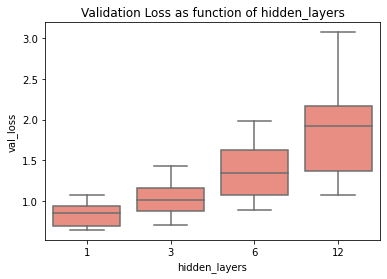

In [60]:
metric = 'hidden_layers'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of first_neuron')

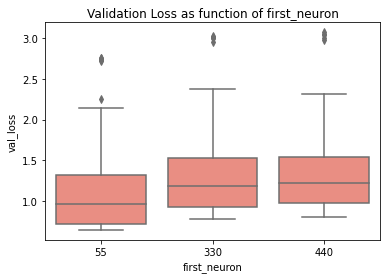

In [61]:
metric = 'first_neuron'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of hidden_neuron')

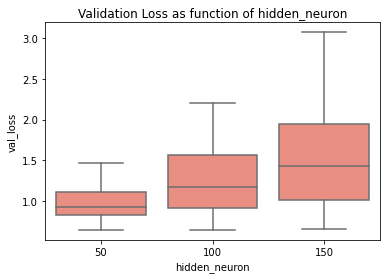

In [62]:
metric = 'hidden_neuron'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of batc_normalization')

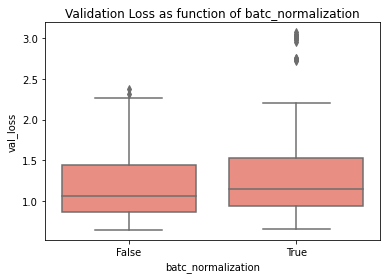

In [63]:
metric = 'batc_normalization'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of activation_layer')

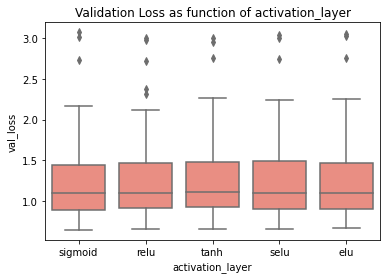

In [64]:
metric = 'activation_layer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


## Part 3.

In [25]:

def numerai_model(x_train, y_train, x_val, y_val, params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(3, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adagrad(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=3,beta=1.0)])
    
  
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        class_weight={0 : 0.64147775,
                                      1 : 2.42539683,
                                      2 : 0.97201018},
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=1,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )

    return history, model

In [29]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[3,6],   

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [64], #Done

    'lr':[0.001,0.0001,0.00001],
    
    'kernel_regularizer_l1':[0.0001],#[0,0.001,0.0001],
    'kernel_regularizer_l2':[0.0001],#[0,0.001,0.0001],
    'bias_regularizer':[0.0001],#[0,0.001,0.0001],
    'activity_regularizer':[0.0001],#[0,0.001,0.0001],

    #'dropout': [0,0.1,0.2,0.3,0.4],
    'dropout': [0],
    
  
    'kernel_initializer': ['orthogonal','identity','uniform'],

    'activation_layer':['sigmoid','tanh','selu','elu','relu'],
 
    'batc_normalization':[False,True],
 
}

In [30]:

t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy T - Weighted binary cross-entropy (softmax)')



  0%|                                                                                          | 0/180 [00:00<?, ?it/s]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function wit

  0%|                                                                                        | 0/450 [2:17:57<?, ?it/s]


  1%|▍                                                                                 | 1/180 [00:08<25:25,  8.52s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function wi



  1%|▉                                                                                 | 2/180 [00:13<18:58,  6.39s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function wit



  2%|█▎                                                                                | 3/180 [00:17<16:22,  5.55s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 



  2%|█▊                                                                                | 4/180 [00:30<24:32,  8.37s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with



  3%|██▎                                                                               | 5/180 [00:36<21:46,  7.47s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 



  3%|██▋                                                                               | 6/180 [00:41<18:45,  6.47s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @



  4%|███▏                                                                              | 7/180 [00:45<16:55,  5.87s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 



  4%|███▋                                                                              | 8/180 [00:50<15:39,  5.46s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @



  5%|████                                                                              | 9/180 [00:55<15:01,  5.27s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To si



  6%|████▌                                                                            | 10/180 [01:04<18:40,  6.59s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To s



  6%|████▉                                                                            | 11/180 [01:10<17:43,  6.29s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To si



  7%|█████▍                                                                           | 12/180 [01:16<17:09,  6.13s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile



  7%|█████▊                                                                           | 13/180 [01:31<24:36,  8.84s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil



  8%|██████▎                                                                          | 14/180 [01:39<24:23,  8.82s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile



  8%|██████▊                                                                          | 15/180 [01:45<21:44,  7.91s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



  9%|███████▏                                                                         | 16/180 [01:52<20:58,  7.68s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile



  9%|███████▋                                                                         | 17/180 [01:59<19:38,  7.23s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



 10%|████████                                                                         | 18/180 [02:05<19:07,  7.08s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with



 11%|████████▌                                                                        | 19/180 [02:14<20:13,  7.54s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function wit



 11%|█████████                                                                        | 20/180 [02:21<19:38,  7.37s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with



 12%|█████████▍                                                                       | 21/180 [02:28<19:12,  7.25s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @



 12%|█████████▉                                                                       | 22/180 [02:44<26:20, 10.00s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 



 13%|██████████▎                                                                      | 23/180 [02:53<25:16,  9.66s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @



 13%|██████████▊                                                                      | 24/180 [03:01<23:31,  9.05s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t



 14%|███████████▎                                                                     | 25/180 [03:09<23:07,  8.95s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @



 14%|███████████▋                                                                     | 26/180 [03:18<23:02,  8.98s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t



 15%|████████████▏                                                                    | 27/180 [03:25<21:10,  8.30s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil



 16%|████████████▌                                                                    | 28/180 [03:34<21:25,  8.46s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To si



 16%|█████████████                                                                    | 29/180 [03:43<22:01,  8.75s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil



 17%|█████████████▌                                                                   | 30/180 [03:53<22:32,  9.02s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



 17%|█████████████▉                                                                   | 31/180 [04:12<30:04, 12.11s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile



 18%|██████████████▍                                                                  | 32/180 [04:22<27:48, 11.27s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



 18%|██████████████▊                                                                  | 33/180 [04:32<26:33, 10.84s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc



 19%|███████████████▎                                                                 | 34/180 [04:45<27:57, 11.49s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



 19%|███████████████▊                                                                 | 35/180 [04:53<25:43, 10.65s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc



 20%|████████████████▏                                                                | 36/180 [05:01<23:34,  9.82s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @



 21%|████████████████▋                                                                | 37/180 [05:09<21:41,  9.10s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 



 21%|█████████████████                                                                | 38/180 [05:13<18:21,  7.76s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @



 22%|█████████████████▌                                                               | 39/180 [05:18<16:10,  6.89s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf



 22%|██████████████████                                                               | 40/180 [05:30<19:24,  8.32s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t



 23%|██████████████████▍                                                              | 41/180 [05:35<17:27,  7.54s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf



 23%|██████████████████▉                                                              | 42/180 [05:40<15:23,  6.69s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 24%|███████████████████▎                                                             | 43/180 [05:45<13:51,  6.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf



 24%|███████████████████▊                                                             | 44/180 [05:50<13:00,  5.74s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 25%|████████████████████▎                                                            | 45/180 [05:55<12:25,  5.52s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



 26%|████████████████████▋                                                            | 46/180 [06:06<15:55,  7.13s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile



 26%|█████████████████████▏                                                           | 47/180 [06:11<14:56,  6.74s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



 27%|█████████████████████▌                                                           | 48/180 [06:17<14:10,  6.44s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 27%|██████████████████████                                                           | 49/180 [06:32<19:29,  8.93s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc



 28%|██████████████████████▌                                                          | 50/180 [06:40<18:40,  8.62s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 28%|██████████████████████▉                                                          | 51/180 [06:45<16:30,  7.68s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 29%|███████████████████████▍                                                         | 52/180 [06:51<14:58,  7.02s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 29%|███████████████████████▊                                                         | 53/180 [06:57<14:05,  6.66s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 30%|████████████████████████▎                                                        | 54/180 [07:02<13:20,  6.35s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t



 31%|████████████████████████▊                                                        | 55/180 [07:08<13:01,  6.25s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @



 31%|█████████████████████████▏                                                       | 56/180 [07:15<13:06,  6.35s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t



 32%|█████████████████████████▋                                                       | 57/180 [07:22<13:18,  6.49s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 32%|██████████████████████████                                                       | 58/180 [07:38<19:29,  9.59s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf



 33%|██████████████████████████▌                                                      | 59/180 [07:47<18:32,  9.20s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 33%|███████████████████████████                                                      | 60/180 [07:54<17:01,  8.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a



 34%|███████████████████████████▍                                                     | 61/180 [08:03<17:32,  8.84s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 34%|███████████████████████████▉                                                     | 62/180 [08:10<15:52,  8.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a



 35%|████████████████████████████▎                                                    | 63/180 [08:16<14:40,  7.52s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc



 36%|████████████████████████████▊                                                    | 64/180 [08:24<15:10,  7.85s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



 36%|█████████████████████████████▎                                                   | 65/180 [08:33<15:36,  8.14s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc



 37%|█████████████████████████████▋                                                   | 66/180 [08:42<15:39,  8.25s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 37%|██████████████████████████████▏                                                  | 67/180 [09:07<25:04, 13.32s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 38%|██████████████████████████████▌                                                  | 68/180 [09:16<22:40, 12.14s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 38%|███████████████████████████████                                                  | 69/180 [09:26<20:56, 11.32s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



 39%|███████████████████████████████▌                                                 | 70/180 [09:40<22:15, 12.14s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 39%|███████████████████████████████▉                                                 | 71/180 [09:52<22:04, 12.15s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



 40%|████████████████████████████████▍                                                | 72/180 [10:01<20:08, 11.19s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @



 41%|████████████████████████████████▊                                                | 73/180 [10:10<18:39, 10.46s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 



 41%|█████████████████████████████████▎                                               | 74/180 [10:15<15:32,  8.79s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @



 42%|█████████████████████████████████▊                                               | 75/180 [10:19<13:18,  7.60s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf



 42%|██████████████████████████████████▏                                              | 76/180 [10:30<14:52,  8.59s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t



 43%|██████████████████████████████████▋                                              | 77/180 [10:35<12:55,  7.52s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf



 43%|███████████████████████████████████                                              | 78/180 [10:40<11:14,  6.62s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 44%|███████████████████████████████████▌                                             | 79/180 [10:44<10:08,  6.02s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf



 44%|████████████████████████████████████                                             | 80/180 [10:48<09:03,  5.44s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 45%|████████████████████████████████████▍                                            | 81/180 [10:53<08:32,  5.17s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



 46%|████████████████████████████████████▉                                            | 82/180 [11:03<10:42,  6.56s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile



 46%|█████████████████████████████████████▎                                           | 83/180 [11:08<10:09,  6.28s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



 47%|█████████████████████████████████████▊                                           | 84/180 [11:14<09:47,  6.12s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 47%|██████████████████████████████████████▎                                          | 85/180 [11:29<13:59,  8.84s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc



 48%|██████████████████████████████████████▋                                          | 86/180 [11:38<13:33,  8.66s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 48%|███████████████████████████████████████▏                                         | 87/180 [11:43<12:05,  7.81s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 49%|███████████████████████████████████████▌                                         | 88/180 [11:49<10:59,  7.16s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 49%|████████████████████████████████████████                                         | 89/180 [11:55<10:10,  6.71s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 50%|████████████████████████████████████████▌                                        | 90/180 [12:01<09:37,  6.42s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t



 51%|████████████████████████████████████████▉                                        | 91/180 [12:15<13:08,  8.86s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @



 51%|█████████████████████████████████████████▍                                       | 92/180 [12:21<11:47,  8.04s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t



 52%|█████████████████████████████████████████▊                                       | 93/180 [12:28<10:56,  7.55s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 52%|██████████████████████████████████████████▎                                      | 94/180 [12:41<13:30,  9.42s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf



 53%|██████████████████████████████████████████▊                                      | 95/180 [12:49<12:24,  8.75s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 53%|███████████████████████████████████████████▏                                     | 96/180 [12:55<11:07,  7.95s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a



 54%|███████████████████████████████████████████▋                                     | 97/180 [13:06<12:24,  8.97s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 54%|████████████████████████████████████████████                                     | 98/180 [13:12<11:05,  8.12s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a



 55%|████████████████████████████████████████████▌                                    | 99/180 [13:18<10:09,  7.52s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc



 56%|████████████████████████████████████████████▍                                   | 100/180 [13:26<10:05,  7.57s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



 56%|████████████████████████████████████████████▉                                   | 101/180 [13:34<10:18,  7.83s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc



 57%|█████████████████████████████████████████████▎                                  | 102/180 [13:43<10:37,  8.17s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 57%|█████████████████████████████████████████████▊                                  | 103/180 [14:02<14:24, 11.22s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 58%|██████████████████████████████████████████████▏                                 | 104/180 [14:11<13:27, 10.63s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 58%|██████████████████████████████████████████████▋                                 | 105/180 [14:20<12:44, 10.19s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



 59%|███████████████████████████████████████████████                                 | 106/180 [14:34<13:57, 11.31s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 59%|███████████████████████████████████████████████▌                                | 107/180 [14:42<12:41, 10.43s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



 60%|████████████████████████████████████████████████                                | 108/180 [14:51<11:49,  9.85s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t



 61%|████████████████████████████████████████████████▍                               | 109/180 [14:57<10:13,  8.64s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @



 61%|████████████████████████████████████████████████▉                               | 110/180 [15:01<08:41,  7.44s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t



 62%|█████████████████████████████████████████████████▎                              | 111/180 [15:06<07:34,  6.58s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 62%|█████████████████████████████████████████████████▊                              | 112/180 [15:18<09:24,  8.30s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf



 63%|██████████████████████████████████████████████████▏                             | 113/180 [15:24<08:26,  7.57s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 63%|██████████████████████████████████████████████████▋                             | 114/180 [15:29<07:18,  6.65s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a



 64%|███████████████████████████████████████████████████                             | 115/180 [15:33<06:29,  5.99s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 64%|███████████████████████████████████████████████████▌                            | 116/180 [15:38<05:56,  5.58s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a



 65%|████████████████████████████████████████████████████                            | 117/180 [15:41<05:17,  5.04s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc



 66%|████████████████████████████████████████████████████▍                           | 118/180 [15:52<07:02,  6.82s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



 66%|████████████████████████████████████████████████████▉                           | 119/180 [15:58<06:32,  6.43s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc



 67%|█████████████████████████████████████████████████████▎                          | 120/180 [16:04<06:12,  6.21s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 67%|█████████████████████████████████████████████████████▊                          | 121/180 [16:19<08:41,  8.84s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 68%|██████████████████████████████████████████████████████▏                         | 122/180 [16:27<08:23,  8.68s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 68%|██████████████████████████████████████████████████████▋                         | 123/180 [16:33<07:25,  7.82s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



 69%|███████████████████████████████████████████████████████                         | 124/180 [16:38<06:40,  7.14s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 69%|███████████████████████████████████████████████████████▌                        | 125/180 [16:44<06:08,  6.69s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



 70%|████████████████████████████████████████████████████████                        | 126/180 [16:50<05:45,  6.39s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf



 71%|████████████████████████████████████████████████████████▍                       | 127/180 [17:03<07:27,  8.44s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t



 71%|████████████████████████████████████████████████████████▉                       | 128/180 [17:09<06:42,  7.73s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf



 72%|█████████████████████████████████████████████████████████▎                      | 129/180 [17:15<06:10,  7.26s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a



 72%|█████████████████████████████████████████████████████████▊                      | 130/180 [17:30<08:04,  9.69s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 73%|██████████████████████████████████████████████████████████▏                     | 131/180 [17:37<07:09,  8.77s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a



 73%|██████████████████████████████████████████████████████████▋                     | 132/180 [17:44<06:29,  8.12s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au



 74%|███████████████████████████████████████████████████████████                     | 133/180 [17:54<06:51,  8.75s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a



 74%|███████████████████████████████████████████████████████████▌                    | 134/180 [18:05<07:18,  9.53s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au



 75%|████████████████████████████████████████████████████████████                    | 135/180 [18:11<06:22,  8.51s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 76%|████████████████████████████████████████████████████████████▍                   | 136/180 [18:20<06:14,  8.50s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc



 76%|████████████████████████████████████████████████████████████▉                   | 137/180 [18:28<06:06,  8.52s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 77%|█████████████████████████████████████████████████████████████▎                  | 138/180 [18:37<05:57,  8.52s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



 77%|█████████████████████████████████████████████████████████████▊                  | 139/180 [18:57<08:17, 12.12s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 78%|██████████████████████████████████████████████████████████████▏                 | 140/180 [19:07<07:30, 11.26s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



 78%|██████████████████████████████████████████████████████████████▋                 | 141/180 [19:17<07:08, 10.98s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence th



 79%|███████████████████████████████████████████████████████████████                 | 142/180 [19:28<06:59, 11.03s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



 79%|███████████████████████████████████████████████████████████████▌                | 143/180 [19:39<06:43, 10.90s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence th



 80%|████████████████████████████████████████████████████████████████                | 144/180 [19:49<06:25, 10.70s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @



 81%|████████████████████████████████████████████████████████████████▍               | 145/180 [19:58<06:01, 10.32s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 



 81%|████████████████████████████████████████████████████████████████▉               | 146/180 [20:03<04:53,  8.63s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @



 82%|█████████████████████████████████████████████████████████████████▎              | 147/180 [20:08<04:03,  7.37s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf



 82%|█████████████████████████████████████████████████████████████████▊              | 148/180 [20:19<04:36,  8.64s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t



 83%|██████████████████████████████████████████████████████████████████▏             | 149/180 [20:25<04:00,  7.76s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf



 83%|██████████████████████████████████████████████████████████████████▋             | 150/180 [20:29<03:24,  6.81s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 84%|███████████████████████████████████████████████████████████████████             | 151/180 [20:34<02:57,  6.13s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf



 84%|███████████████████████████████████████████████████████████████████▌            | 152/180 [20:39<02:38,  5.65s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 85%|████████████████████████████████████████████████████████████████████            | 153/180 [20:43<02:24,  5.34s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



 86%|████████████████████████████████████████████████████████████████████▍           | 154/180 [20:52<02:45,  6.35s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile



 86%|████████████████████████████████████████████████████████████████████▉           | 155/180 [20:58<02:34,  6.18s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



 87%|█████████████████████████████████████████████████████████████████████▎          | 156/180 [21:03<02:24,  6.03s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 87%|█████████████████████████████████████████████████████████████████████▊          | 157/180 [21:19<03:22,  8.79s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc



 88%|██████████████████████████████████████████████████████████████████████▏         | 158/180 [21:26<03:07,  8.52s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 88%|██████████████████████████████████████████████████████████████████████▋         | 159/180 [21:32<02:40,  7.64s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 89%|███████████████████████████████████████████████████████████████████████         | 160/180 [21:37<02:18,  6.91s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 89%|███████████████████████████████████████████████████████████████████████▌        | 161/180 [21:42<02:00,  6.36s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 90%|████████████████████████████████████████████████████████████████████████        | 162/180 [21:47<01:46,  5.94s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t



 91%|████████████████████████████████████████████████████████████████████████▍       | 163/180 [21:54<01:42,  6.05s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @



 91%|████████████████████████████████████████████████████████████████████████▉       | 164/180 [21:59<01:34,  5.93s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @t



 92%|█████████████████████████████████████████████████████████████████████████▎      | 165/180 [22:05<01:27,  5.84s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 92%|█████████████████████████████████████████████████████████████████████████▊      | 166/180 [22:20<02:01,  8.66s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf



 93%|██████████████████████████████████████████████████████████████████████████▏     | 167/180 [22:28<01:51,  8.56s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 93%|██████████████████████████████████████████████████████████████████████████▋     | 168/180 [22:35<01:34,  7.88s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a



 94%|███████████████████████████████████████████████████████████████████████████     | 169/180 [22:45<01:33,  8.50s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.



 94%|███████████████████████████████████████████████████████████████████████████▌    | 170/180 [22:51<01:18,  7.81s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a



 95%|████████████████████████████████████████████████████████████████████████████    | 171/180 [22:57<01:05,  7.33s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc



 96%|████████████████████████████████████████████████████████████████████████████▍   | 172/180 [23:06<01:01,  7.70s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



 96%|████████████████████████████████████████████████████████████████████████████▉   | 173/180 [23:14<00:55,  7.92s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc



 97%|█████████████████████████████████████████████████████████████████████████████▎  | 174/180 [23:22<00:48,  8.03s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 97%|█████████████████████████████████████████████████████████████████████████████▊  | 175/180 [23:40<00:53, 10.80s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 98%|██████████████████████████████████████████████████████████████████████████████▏ | 176/180 [23:49<00:41, 10.31s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 98%|██████████████████████████████████████████████████████████████████████████████▋ | 177/180 [23:58<00:30, 10.06s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



 99%|███████████████████████████████████████████████████████████████████████████████ | 178/180 [24:13<00:23, 11.58s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 99%|███████████████████████████████████████████████████████████████████████████████▌| 179/180 [24:22<00:10, 10.68s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [24:31<00:00,  8.17s/it]


In [32]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/T/Predykcja klasy T - Weighted binary cross-entropy (softmax)/051022112345.csv')

In [33]:
df 

,round_epochs,loss,fbeta_score,val_loss,val_fbeta_score,activation_layer,activity_regularizer,batc_normalization,batch_size,bias_regularizer,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
0,142,0.788577,[0.18021978 0.27045074 0.39662445],0.808301,[0.27868852 0.24324326 0.33928573],sigmoid,0.0001,False,64,0.0001,0,100000,55,3,50,orthogonal,0.0001,0.0001,sigmoid,0.00100
1,51,0.843735,[0.65913373 0. 0.23398326],0.826114,[0.67647064 0. 0.1686747 ],sigmoid,0.0001,False,64,0.0001,0,100000,55,3,50,orthogonal,0.0001,0.0001,sigmoid,0.00010
2,51,0.852544,[0.3621795 0.22812499 0.00757576],0.857135,[0.38993707 0.21518989 0. ],sigmoid,0.0001,False,64,0.0001,0,100000,55,3,50,orthogonal,0.0001,0.0001,sigmoid,0.00001
3,243,0.680800,[0.44206774 0.26959246 0.47839507],0.691966,[0.5298013 0.30136985 0.5189873 ],sigmoid,0.0001,False,64,0.0001,0,100000,55,3,50,identity,0.0001,0.0001,sigmoid,0.00100
4,81,0.832624,[0.57342654 0.20578778 0.42231074],0.828862,[0.6231156 0.2535211 0.37500003],sigmoid,0.0001,False,64,0.0001,0,100000,55,3,50,identity,0.0001,0.0001,sigmoid,0.00010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,61,0.863381,[0.55925435 0.25757578 0.4093567 ],0.858388,[0.7520001 0.39215687 0.27160496],relu,0.0001,True,64,0.0001,0,100000,55,6,50,identity,0.0001,0.0001,sigmoid,0.00010
176,62,0.881856,[0.53061223 0.17721517 0.2882096 ],0.862929,[0.72727275 0.17142858 0.28915665],relu,0.0001,True,64,0.0001,0,100000,55,6,50,identity,0.0001,0.0001,sigmoid,0.00001
177,100,0.467637,[0.82368773 0.67353946 0.77327937],0.688074,[0.7623763 0.20689656 0.59016395],relu,0.0001,True,64,0.0001,0,100000,55,6,50,uniform,0.0001,0.0001,sigmoid,0.00100
178,51,0.729925,[0.49216306 0.2762431 0.39393938],0.739474,[0.6728972 0.2 0.37288135],relu,0.0001,True,64,0.0001,0,100000,55,6,50,uniform,0.0001,0.0001,sigmoid,0.00010


In [36]:
df=df.sort_values('val_loss',ascending=True)

In [37]:
df

,round_epochs,loss,fbeta_score,val_loss,val_fbeta_score,activation_layer,activity_regularizer,batc_normalization,batch_size,bias_regularizer,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
168,142,0.462458,[0.7496423 0.59171593 0.72505087],0.642904,[0.73333335 0.35820895 0.62222224],relu,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,0.0001,0.0001,sigmoid,0.00100
132,134,0.463715,[0.83029455 0.6125 0.8 ],0.652939,[0.6871795 0.29411763 0.5546218 ],elu,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,0.0001,0.0001,sigmoid,0.00100
96,149,0.453368,[0.79096043 0.61829656 0.7554672 ],0.662958,[0.70212764 0.2608696 0.54399997],selu,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,0.0001,0.0001,sigmoid,0.00100
105,140,0.401244,[0.8306011 0.72527474 0.8183556 ],0.676724,[0.69 0.3272727 0.5511811],selu,0.0001,True,64,0.0001,0,100000,55,6,50,uniform,0.0001,0.0001,sigmoid,0.00100
177,100,0.467637,[0.82368773 0.67353946 0.77327937],0.688074,[0.7623763 0.20689656 0.59016395],relu,0.0001,True,64,0.0001,0,100000,55,6,50,uniform,0.0001,0.0001,sigmoid,0.00100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,51,1.043084,[0.40298507 0.18289088 0.33140656],1.062600,[0.483146 0.19277109 0.3471074 ],relu,0.0001,True,64,0.0001,0,100000,55,6,50,orthogonal,0.0001,0.0001,sigmoid,0.00010
101,51,1.090095,[0.32225913 0.21700878 0.34871793],1.089784,[0.37209302 0.24390246 0.203125 ],selu,0.0001,True,64,0.0001,0,100000,55,6,50,orthogonal,0.0001,0.0001,sigmoid,0.00001
64,51,1.071666,[0.37320575 0.20630373 0.3768116 ],1.091396,[0.33734939 0.11428571 0.39726025],tanh,0.0001,True,64,0.0001,0,100000,55,6,50,orthogonal,0.0001,0.0001,sigmoid,0.00010
65,51,1.052512,[0.44 0.25 0.36679533],1.091743,[0.39215687 0.21428572 0.28965518],tanh,0.0001,True,64,0.0001,0,100000,55,6,50,orthogonal,0.0001,0.0001,sigmoid,0.00001


Text(0.5, 1.0, 'Validation Loss as function of hidden_layers')

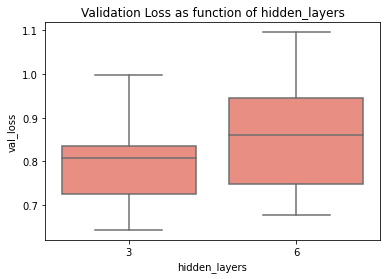

In [38]:
metric = 'hidden_layers'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of lr')

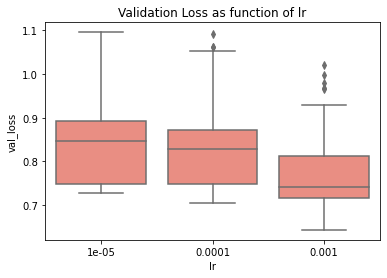

In [39]:
metric = 'lr'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of kernel_initializer')

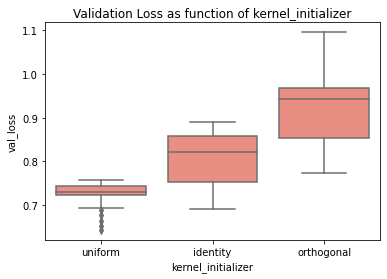

In [40]:
metric = 'kernel_initializer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of activation_layer')

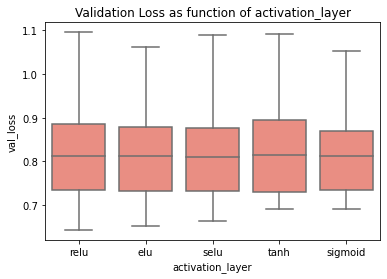

In [41]:
metric = 'activation_layer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of batc_normalization')

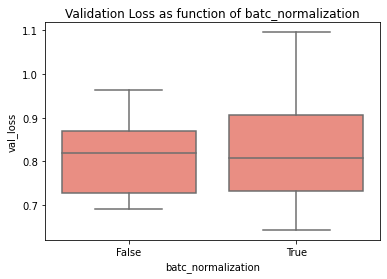

In [42]:
metric = 'batc_normalization'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

## Part 4

In [ ]:

def numerai_model(x_train, y_train, x_val, y_val, params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(3, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adagrad(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=3,beta=1.0)])
    
  
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        class_weight={0 : 0.64147775,
                                      1 : 2.42539683,
                                      2 : 0.97201018},
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=1,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )

    return history, model

In [43]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[3],   

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [64], #Done

    'lr':[0.001],
    
    'kernel_regularizer_l1':[0.1,0.01,0.001,0.0001],
    'kernel_regularizer_l2':[0.1,0.01,0.001,0.0001],
    'bias_regularizer':[0.1,0.01,0.001,0.0001],
    'activity_regularizer':[0.1,0.01,0.001,0.0001],

    #'dropout': [0,0.1,0.2,0.3,0.4],
    'dropout': [0],
    
  
    'kernel_initializer': ['uniform'],

    'activation_layer':['sigmoid','tanh','selu','elu','relu'],
 
    'batc_normalization':[False,True],
 
}

In [ ]:

t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy T - Weighted binary cross-entropy (softmax)')

In [45]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/T/Predykcja klasy T - Weighted binary cross-entropy (softmax)/051022120641.csv')

In [46]:
df

,round_epochs,loss,fbeta_score,val_loss,val_fbeta_score,activation_layer,activity_regularizer,batc_normalization,batch_size,bias_regularizer,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
0,157,0.763430,[0. 0. 0.5107212],0.763316,[0. 0. 0.5078125],sigmoid,0.1000,False,64,0.1000,0,100000,55,3,50,uniform,0.1000,0.1000,sigmoid,0.001
1,143,0.764906,[0. 0.24165708 0. ],0.764889,[0. 0.24770641 0. ],sigmoid,0.1000,False,64,0.1000,0,100000,55,3,50,uniform,0.1000,0.0100,sigmoid,0.001
2,148,0.764132,[0. 0. 0.5107212],0.764032,[0. 0. 0.5078125],sigmoid,0.1000,False,64,0.1000,0,100000,55,3,50,uniform,0.1000,0.0010,sigmoid,0.001
3,149,0.764111,[0. 0. 0.5107212],0.763977,[0. 0. 0.5078125],sigmoid,0.1000,False,64,0.1000,0,100000,55,3,50,uniform,0.1000,0.0001,sigmoid,0.001
4,203,0.753764,[0. 0.19631903 0.3800623 ],0.753720,[0. 0.24770641 0. ],sigmoid,0.1000,False,64,0.1000,0,100000,55,3,50,uniform,0.0100,0.1000,sigmoid,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,153,0.686211,[0.80551726 0.6261981 0.8040817 ],0.922833,[0.69273746 0.2368421 0.5354331 ],relu,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,0.0010,0.0001,sigmoid,0.001
2556,204,0.557201,[0.9124669 0.8015564 0.89748555],0.982316,[0.6631016 0.31428573 0.464 ],relu,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,0.0001,0.1000,sigmoid,0.001
2557,168,0.518566,[0.796034 0.64102566 0.78431374],0.721161,[0.72131157 0.3030303 0.54135346],relu,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,0.0001,0.0100,sigmoid,0.001
2558,145,0.454206,[0.7788595 0.631579 0.780198 ],0.652408,[0.6999999 0.3125 0.5084745],relu,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,0.0001,0.0010,sigmoid,0.001


In [47]:
df=df.sort_values('val_loss',ascending=True)

In [48]:
df

,round_epochs,loss,fbeta_score,val_loss,val_fbeta_score,activation_layer,activity_regularizer,batc_normalization,batch_size,bias_regularizer,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
1007,145,0.443156,[0.77607787 0.63870966 0.737475 ],0.628446,[0.70212764 0.26865673 0.5511811 ],tanh,0.0001,True,64,0.0010,0,100000,55,3,50,uniform,0.0001,0.0001,sigmoid,0.001
974,129,0.482130,[0.77521616 0.60307693 0.78585464],0.631428,[0.75132275 0.3548387 0.610687 ],tanh,0.0001,True,64,0.1000,0,100000,55,3,50,uniform,0.0001,0.0010,sigmoid,0.001
1407,174,0.428074,[0.80547947 0.6513158 0.78542507],0.634222,[0.7027027 0.36363637 0.5954198 ],selu,0.0010,True,64,0.0001,0,100000,55,3,50,uniform,0.0001,0.0001,sigmoid,0.001
1870,150,0.459109,[0.79286695 0.6486486 0.7594434 ],0.634712,[0.71219504 0.31578952 0.5333333 ],elu,0.0010,True,64,0.1000,0,100000,55,3,50,uniform,0.0001,0.0010,sigmoid,0.001
895,125,0.457421,[0.76676387 0.6292835 0.73704416],0.640150,[0.70157063 0.32258064 0.5736434 ],tanh,0.0010,True,64,0.0001,0,100000,55,3,50,uniform,0.0001,0.0001,sigmoid,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,75,1.066042,[0.7249647 0.55647385 0.67543864],1.297326,[0.4166667 0.21487604 0.41025642],elu,0.1000,True,64,0.1000,0,100000,55,3,50,uniform,0.0010,0.0010,sigmoid,0.001
2122,75,1.056130,[0.7427745 0.5756677 0.7735471],1.303543,[0.62195116 0.25742573 0.4615385 ],relu,0.1000,True,64,0.1000,0,100000,55,3,50,uniform,0.0010,0.0010,sigmoid,0.001
1657,158,0.826383,[0.8622589 0.74725276 0.8582231 ],1.304378,[0.5189873 0.21428572 0.3857143 ],elu,0.1000,True,64,0.0001,0,100000,55,3,50,uniform,0.0010,0.0100,sigmoid,0.001
1624,237,0.705741,[0.9352331 0.8644067 0.93461543],1.308194,[0.6421053 0.2535211 0.36363637],elu,0.1000,True,64,0.0100,0,100000,55,3,50,uniform,0.0010,0.1000,sigmoid,0.001


Text(0.5, 1.0, 'Validation Loss as function of kernel_regularizer_l1')

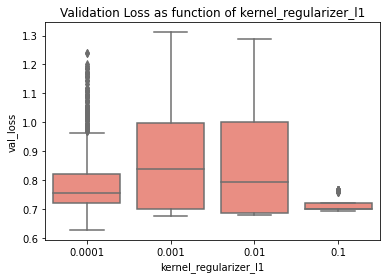

In [49]:
metric = 'kernel_regularizer_l1'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of kernel_regularizer_l2')

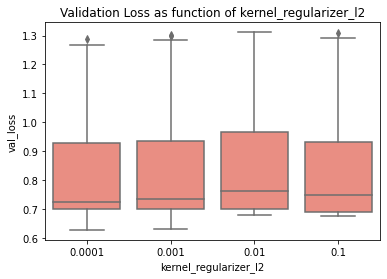

In [50]:
metric = 'kernel_regularizer_l2'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of bias_regularizer')

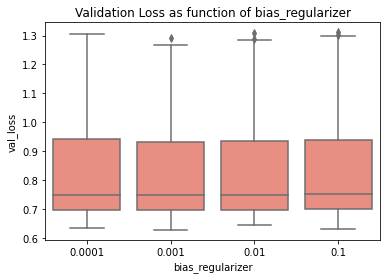

In [51]:
metric = 'bias_regularizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of activity_regularizer')

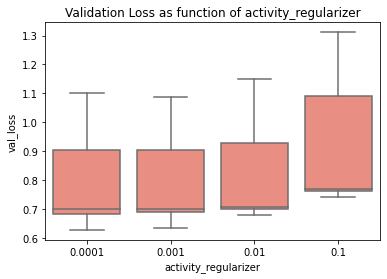

In [52]:
metric = 'activity_regularizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of batc_normalization')

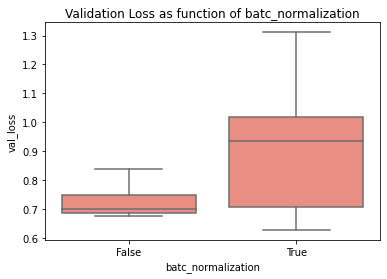

In [53]:
metric = 'batc_normalization'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of activation_layer')

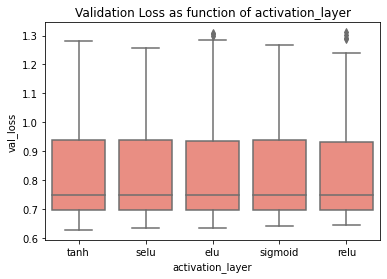

In [54]:
metric = 'activation_layer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

## Part 5

In [55]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[3],   #Done

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [64], #Done

    'lr':[0.001],#Done
    
    'kernel_regularizer_l1':[0.1,0.0001,0.00001],
    'kernel_regularizer_l2':[0.1,0.0001,0.00001],
    'bias_regularizer':[0.0001,0.00001],
    'activity_regularizer':[0.001,0.0001,0.00001],

    #'dropout': [0,0.1,0.2,0.3,0.4],
    'dropout': [0],
    
  
    'kernel_initializer': ['uniform'],#Done

    'activation_layer':['tanh','selu'],
 
    'batc_normalization':[False,True],
 
}

In [56]:

t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy T - Weighted binary cross-entropy (softmax)')

  0%|                                                                                          | 0/216 [00:00<?, ?it/s]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

  0%|▍                                                                                 | 1/216 [00:06<24:22,  6.80s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

  1%|▊                                                                                 | 2/216 [00:13<24:49,  6.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

  1%|█▏                                                                                | 3/216 [00:22<27:06,  7.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

  2%|█▌                                                                                | 4/216 [00:40<42:17, 11.97s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

  2%|█▉                                                                                | 5/216 [00:45<32:07,  9.14s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

  3%|██▎                                                                               | 6/216 [00:49<26:02,  7.44s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

  3%|██▋                                                                               | 7/216 [01:08<38:56, 11.18s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

  4%|███                                                                               | 8/216 [01:12<30:58,  8.94s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

  4%|███▍                                                                              | 9/216 [01:16<25:22,  7.35s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograp

  5%|███▊                                                                             | 10/216 [01:24<26:18,  7.66s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

  5%|████▏                                                                            | 11/216 [01:31<25:36,  7.49s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

  6%|████▌                                                                            | 12/216 [01:38<25:00,  7.36s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

  6%|████▉                                                                            | 13/216 [01:56<35:49, 10.59s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

  6%|█████▎                                                                           | 14/216 [02:00<29:10,  8.67s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

  7%|█████▋                                                                           | 15/216 [02:04<24:25,  7.29s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

  7%|██████                                                                           | 16/216 [02:24<36:40, 11.00s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

  8%|██████▍                                                                          | 17/216 [02:28<29:48,  8.99s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

  8%|██████▊                                                                          | 18/216 [02:32<24:46,  7.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograp

  9%|███████▏                                                                         | 19/216 [02:41<26:08,  7.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

  9%|███████▌                                                                         | 20/216 [02:50<26:57,  8.25s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 10%|███████▉                                                                         | 21/216 [03:01<29:36,  9.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 10%|████████▎                                                                        | 22/216 [03:14<33:01, 10.21s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 11%|████████▋                                                                        | 23/216 [03:23<31:45,  9.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 11%|█████████                                                                        | 24/216 [03:31<29:49,  9.32s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 12%|█████████▍                                                                       | 25/216 [03:46<34:21, 10.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 12%|█████████▊                                                                       | 26/216 [03:55<32:45, 10.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 12%|██████████▏                                                                      | 27/216 [04:03<30:22,  9.65s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph

 13%|██████████▌                                                                      | 28/216 [04:12<29:30,  9.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 13%|██████████▉                                                                      | 29/216 [04:21<28:49,  9.25s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

 14%|███████████▎                                                                     | 30/216 [04:29<27:33,  8.89s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 14%|███████████▋                                                                     | 31/216 [04:42<31:28, 10.21s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 15%|████████████                                                                     | 32/216 [04:49<28:43,  9.37s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 15%|████████████▍                                                                    | 33/216 [04:58<28:09,  9.23s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

 16%|████████████▊                                                                    | 34/216 [05:13<32:52, 10.84s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 16%|█████████████▏                                                                   | 35/216 [05:23<31:53, 10.57s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 17%|█████████████▌                                                                   | 36/216 [05:33<31:09, 10.38s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 17%|█████████████▉                                                                   | 37/216 [05:40<28:14,  9.47s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 18%|██████████████▎                                                                  | 38/216 [05:47<26:00,  8.77s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 18%|██████████████▋                                                                  | 39/216 [05:54<24:28,  8.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 19%|███████████████                                                                  | 40/216 [06:13<33:24, 11.39s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 19%|███████████████▍                                                                 | 41/216 [06:17<26:37,  9.13s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 19%|███████████████▊                                                                 | 42/216 [06:21<21:58,  7.58s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 20%|████████████████▏                                                                | 43/216 [06:39<30:38, 10.63s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 20%|████████████████▌                                                                | 44/216 [06:43<24:46,  8.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 21%|████████████████▉                                                                | 45/216 [06:47<20:43,  7.27s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

 21%|█████████████████▎                                                               | 46/216 [06:54<20:24,  7.20s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 22%|█████████████████▋                                                               | 47/216 [07:01<20:21,  7.23s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 22%|██████████████████                                                               | 48/216 [07:08<20:20,  7.26s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 23%|██████████████████▍                                                              | 49/216 [07:25<28:25, 10.21s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 23%|██████████████████▊                                                              | 50/216 [07:29<23:07,  8.36s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 24%|███████████████████▏                                                             | 51/216 [07:34<19:25,  7.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 24%|███████████████████▌                                                             | 52/216 [07:51<27:45, 10.16s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 25%|███████████████████▉                                                             | 53/216 [07:55<22:35,  8.32s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 25%|████████████████████▎                                                            | 54/216 [07:59<18:55,  7.01s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

 25%|████████████████████▋                                                            | 55/216 [08:07<19:56,  7.43s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 26%|█████████████████████                                                            | 56/216 [08:16<20:49,  7.81s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 26%|█████████████████████▍                                                           | 57/216 [08:24<21:13,  8.01s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 27%|█████████████████████▊                                                           | 58/216 [08:40<26:48, 10.18s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 27%|██████████████████████▏                                                          | 59/216 [08:48<24:53,  9.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 28%|██████████████████████▌                                                          | 60/216 [08:58<25:33,  9.83s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 28%|██████████████████████▊                                                          | 61/216 [09:12<28:11, 10.91s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 29%|███████████████████████▎                                                         | 62/216 [09:20<25:59, 10.13s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 29%|███████████████████████▋                                                         | 63/216 [09:29<24:37,  9.66s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograp

 30%|████████████████████████                                                         | 64/216 [09:37<23:48,  9.40s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 30%|████████████████████████▍                                                        | 65/216 [09:46<23:17,  9.25s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 31%|████████████████████████▊                                                        | 66/216 [09:55<22:46,  9.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 31%|█████████████████████████▏                                                       | 67/216 [10:09<26:22, 10.62s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 31%|█████████████████████████▌                                                       | 68/216 [10:18<24:59, 10.13s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 32%|█████████████████████████▊                                                       | 69/216 [10:29<25:29, 10.41s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 32%|██████████████████████████▎                                                      | 70/216 [10:43<27:53, 11.47s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 33%|██████████████████████████▋                                                      | 71/216 [10:54<27:19, 11.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 33%|███████████████████████████                                                      | 72/216 [11:03<25:16, 10.53s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

 34%|███████████████████████████▍                                                     | 73/216 [11:10<22:59,  9.65s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 34%|███████████████████████████▊                                                     | 74/216 [11:17<20:59,  8.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 35%|████████████████████████████▏                                                    | 75/216 [11:24<19:26,  8.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 35%|████████████████████████████▌                                                    | 76/216 [11:42<25:36, 10.98s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 36%|████████████████████████████▊                                                    | 77/216 [11:46<20:37,  8.90s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 36%|█████████████████████████████▎                                                   | 78/216 [11:50<17:03,  7.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 37%|█████████████████████████████▋                                                   | 79/216 [12:07<23:45, 10.40s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 37%|██████████████████████████████                                                   | 80/216 [12:11<19:09,  8.45s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 38%|██████████████████████████████▍                                                  | 81/216 [12:15<16:00,  7.12s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograp

 38%|██████████████████████████████▊                                                  | 82/216 [12:23<16:13,  7.27s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 38%|███████████████████████████████▏                                                 | 83/216 [12:31<16:43,  7.54s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 39%|███████████████████████████████▌                                                 | 84/216 [12:39<17:09,  7.80s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 39%|███████████████████████████████▉                                                 | 85/216 [13:00<25:36, 11.73s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 40%|████████████████████████████████▎                                                | 86/216 [13:05<21:03,  9.72s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 40%|████████████████████████████████▋                                                | 87/216 [13:10<17:53,  8.32s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 41%|█████████████████████████████████                                                | 88/216 [13:30<25:28, 11.94s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 41%|█████████████████████████████████▍                                               | 89/216 [13:35<20:48,  9.83s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 42%|█████████████████████████████████▊                                               | 90/216 [13:40<17:25,  8.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograp

 42%|██████████████████████████████████▏                                              | 91/216 [13:50<18:25,  8.85s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 43%|██████████████████████████████████▌                                              | 92/216 [14:00<18:46,  9.09s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 43%|██████████████████████████████████▉                                              | 93/216 [14:10<19:05,  9.31s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 44%|███████████████████████████████████▎                                             | 94/216 [14:24<21:43, 10.69s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 44%|███████████████████████████████████▋                                             | 95/216 [14:33<20:44, 10.29s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 44%|████████████████████████████████████                                             | 96/216 [14:43<20:11, 10.09s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 45%|████████████████████████████████████▍                                            | 97/216 [14:58<23:06, 11.65s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 45%|████████████████████████████████████▊                                            | 98/216 [15:08<21:45, 11.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 46%|█████████████████████████████████████▏                                           | 99/216 [15:17<20:29, 10.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph

 46%|█████████████████████████████████████                                           | 100/216 [15:27<19:52, 10.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 47%|█████████████████████████████████████▍                                          | 101/216 [15:35<18:53,  9.86s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

 47%|█████████████████████████████████████▊                                          | 102/216 [15:44<17:46,  9.36s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 48%|██████████████████████████████████████▏                                         | 103/216 [15:59<21:17, 11.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 48%|██████████████████████████████████████▌                                         | 104/216 [16:09<20:00, 10.72s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 49%|██████████████████████████████████████▉                                         | 105/216 [16:20<20:12, 10.92s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

 49%|███████████████████████████████████████▎                                        | 106/216 [16:34<21:34, 11.77s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 50%|███████████████████████████████████████▋                                        | 107/216 [16:45<20:51, 11.48s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 50%|████████████████████████████████████████                                        | 108/216 [16:55<20:13, 11.24s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

 50%|████████████████████████████████████████▎                                       | 109/216 [17:03<18:16, 10.25s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 51%|████████████████████████████████████████▋                                       | 110/216 [17:11<16:37,  9.41s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 51%|█████████████████████████████████████████                                       | 111/216 [17:19<15:42,  8.98s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 52%|█████████████████████████████████████████▍                                      | 112/216 [17:37<20:29, 11.82s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 52%|█████████████████████████████████████████▊                                      | 113/216 [17:42<16:25,  9.56s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 53%|██████████████████████████████████████████▏                                     | 114/216 [17:46<13:45,  8.09s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 53%|██████████████████████████████████████████▌                                     | 115/216 [18:06<19:40, 11.69s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 54%|██████████████████████████████████████████▉                                     | 116/216 [18:11<15:53,  9.53s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 54%|███████████████████████████████████████████▎                                    | 117/216 [18:15<13:14,  8.02s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograp

 55%|███████████████████████████████████████████▋                                    | 118/216 [18:23<12:55,  7.92s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 55%|████████████████████████████████████████████                                    | 119/216 [18:31<12:44,  7.89s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 56%|████████████████████████████████████████████▍                                   | 120/216 [18:39<12:41,  7.93s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 56%|████████████████████████████████████████████▊                                   | 121/216 [18:59<18:18, 11.57s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 56%|█████████████████████████████████████████████▏                                  | 122/216 [19:03<14:42,  9.38s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 57%|█████████████████████████████████████████████▌                                  | 123/216 [19:08<12:20,  7.96s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 57%|█████████████████████████████████████████████▉                                  | 124/216 [19:27<17:29, 11.40s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 58%|██████████████████████████████████████████████▎                                 | 125/216 [19:32<14:05,  9.30s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 58%|██████████████████████████████████████████████▋                                 | 126/216 [19:36<11:47,  7.86s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograp

 59%|███████████████████████████████████████████████                                 | 127/216 [19:46<12:32,  8.46s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 59%|███████████████████████████████████████████████▍                                | 128/216 [19:55<12:45,  8.70s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 60%|███████████████████████████████████████████████▊                                | 129/216 [20:05<13:01,  8.98s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 60%|████████████████████████████████████████████████▏                               | 130/216 [20:19<15:02, 10.49s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 61%|████████████████████████████████████████████████▌                               | 131/216 [20:30<15:00, 10.59s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 61%|████████████████████████████████████████████████▉                               | 132/216 [20:40<14:35, 10.43s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 62%|█████████████████████████████████████████████████▎                              | 133/216 [20:55<16:21, 11.83s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 62%|█████████████████████████████████████████████████▋                              | 134/216 [21:04<14:52, 10.89s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 62%|██████████████████████████████████████████████████                              | 135/216 [21:13<13:55, 10.32s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph

 63%|██████████████████████████████████████████████████▎                             | 136/216 [21:22<13:24, 10.05s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 63%|██████████████████████████████████████████████████▋                             | 137/216 [21:31<13:01,  9.89s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

 64%|███████████████████████████████████████████████████                             | 138/216 [21:41<12:52,  9.90s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 64%|███████████████████████████████████████████████████▍                            | 139/216 [21:57<15:00, 11.70s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 65%|███████████████████████████████████████████████████▊                            | 140/216 [22:06<13:41, 10.81s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 65%|████████████████████████████████████████████████████▏                           | 141/216 [22:18<13:48, 11.05s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

 66%|████████████████████████████████████████████████████▌                           | 142/216 [22:32<15:02, 12.19s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 66%|████████████████████████████████████████████████████▉                           | 143/216 [22:43<14:15, 11.72s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 67%|█████████████████████████████████████████████████████▎                          | 144/216 [22:55<13:57, 11.64s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 67%|█████████████████████████████████████████████████████▋                          | 145/216 [23:03<12:34, 10.63s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 68%|██████████████████████████████████████████████████████                          | 146/216 [23:12<11:48, 10.12s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 68%|██████████████████████████████████████████████████████▍                         | 147/216 [23:20<10:52,  9.45s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 69%|██████████████████████████████████████████████████████▊                         | 148/216 [23:38<13:35, 12.00s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 69%|███████████████████████████████████████████████████████▏                        | 149/216 [23:42<10:41,  9.58s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 69%|███████████████████████████████████████████████████████▌                        | 150/216 [23:45<08:40,  7.89s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 70%|███████████████████████████████████████████████████████▉                        | 151/216 [24:03<11:50, 10.92s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 70%|████████████████████████████████████████████████████████▎                       | 152/216 [24:07<09:26,  8.85s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 71%|████████████████████████████████████████████████████████▋                       | 153/216 [24:11<07:45,  7.39s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

 71%|█████████████████████████████████████████████████████████                       | 154/216 [24:18<07:28,  7.24s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 72%|█████████████████████████████████████████████████████████▍                      | 155/216 [24:25<07:15,  7.14s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 72%|█████████████████████████████████████████████████████████▊                      | 156/216 [24:33<07:10,  7.18s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 73%|██████████████████████████████████████████████████████████▏                     | 157/216 [24:51<10:28, 10.66s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 73%|██████████████████████████████████████████████████████████▌                     | 158/216 [24:56<08:26,  8.74s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 74%|██████████████████████████████████████████████████████████▉                     | 159/216 [25:00<06:57,  7.33s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 74%|███████████████████████████████████████████████████████████▎                    | 160/216 [25:18<09:58, 10.69s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 75%|███████████████████████████████████████████████████████████▋                    | 161/216 [25:22<07:58,  8.70s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 75%|████████████████████████████████████████████████████████████                    | 162/216 [25:26<06:35,  7.33s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

 75%|████████████████████████████████████████████████████████████▎                   | 163/216 [25:35<06:47,  7.69s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 76%|████████████████████████████████████████████████████████████▋                   | 164/216 [25:44<06:55,  7.99s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 76%|█████████████████████████████████████████████████████████████                   | 165/216 [25:52<06:54,  8.13s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 77%|█████████████████████████████████████████████████████████████▍                  | 166/216 [26:06<08:10,  9.81s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 77%|█████████████████████████████████████████████████████████████▊                  | 167/216 [26:15<07:51,  9.63s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 78%|██████████████████████████████████████████████████████████████▏                 | 168/216 [26:23<07:25,  9.28s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 78%|██████████████████████████████████████████████████████████████▌                 | 169/216 [26:38<08:27, 10.80s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 79%|██████████████████████████████████████████████████████████████▉                 | 170/216 [26:46<07:44, 10.09s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 79%|███████████████████████████████████████████████████████████████▎                | 171/216 [26:54<07:03,  9.42s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograp

 80%|███████████████████████████████████████████████████████████████▋                | 172/216 [27:02<06:33,  8.95s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 80%|████████████████████████████████████████████████████████████████                | 173/216 [27:10<06:08,  8.56s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 81%|████████████████████████████████████████████████████████████████▍               | 174/216 [27:17<05:46,  8.25s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 81%|████████████████████████████████████████████████████████████████▊               | 175/216 [27:28<06:08,  9.00s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 81%|█████████████████████████████████████████████████████████████████▏              | 176/216 [27:35<05:39,  8.49s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 82%|█████████████████████████████████████████████████████████████████▌              | 177/216 [27:42<05:14,  8.06s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 82%|█████████████████████████████████████████████████████████████████▉              | 178/216 [27:54<05:46,  9.13s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 83%|██████████████████████████████████████████████████████████████████▎             | 179/216 [28:02<05:25,  8.78s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 83%|██████████████████████████████████████████████████████████████████▋             | 180/216 [28:10<05:07,  8.55s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

 84%|███████████████████████████████████████████████████████████████████             | 181/216 [28:16<04:36,  7.90s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 84%|███████████████████████████████████████████████████████████████████▍            | 182/216 [28:23<04:14,  7.48s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 85%|███████████████████████████████████████████████████████████████████▊            | 183/216 [28:29<03:56,  7.17s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 85%|████████████████████████████████████████████████████████████████████▏           | 184/216 [28:45<05:16,  9.89s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 86%|████████████████████████████████████████████████████████████████████▌           | 185/216 [28:49<04:08,  8.03s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 86%|████████████████████████████████████████████████████████████████████▉           | 186/216 [28:53<03:21,  6.72s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 87%|█████████████████████████████████████████████████████████████████████▎          | 187/216 [29:09<04:36,  9.54s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 87%|█████████████████████████████████████████████████████████████████████▋          | 188/216 [29:13<03:38,  7.79s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 88%|██████████████████████████████████████████████████████████████████████          | 189/216 [29:16<02:57,  6.58s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograp

 88%|██████████████████████████████████████████████████████████████████████▎         | 190/216 [29:23<02:51,  6.59s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 88%|██████████████████████████████████████████████████████████████████████▋         | 191/216 [29:30<02:45,  6.61s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 89%|███████████████████████████████████████████████████████████████████████         | 192/216 [29:36<02:39,  6.65s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 89%|███████████████████████████████████████████████████████████████████████▍        | 193/216 [29:54<03:47,  9.91s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 90%|███████████████████████████████████████████████████████████████████████▊        | 194/216 [29:58<02:59,  8.15s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 90%|████████████████████████████████████████████████████████████████████████▏       | 195/216 [30:02<02:25,  6.92s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 91%|████████████████████████████████████████████████████████████████████████▌       | 196/216 [30:19<03:21, 10.10s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 91%|████████████████████████████████████████████████████████████████████████▉       | 197/216 [30:23<02:36,  8.26s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 92%|█████████████████████████████████████████████████████████████████████████▎      | 198/216 [30:27<02:06,  7.00s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograp

 92%|█████████████████████████████████████████████████████████████████████████▋      | 199/216 [30:36<02:08,  7.56s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 93%|██████████████████████████████████████████████████████████████████████████      | 200/216 [30:45<02:06,  7.90s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 93%|██████████████████████████████████████████████████████████████████████████▍     | 201/216 [30:54<02:03,  8.20s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

 94%|██████████████████████████████████████████████████████████████████████████▊     | 202/216 [31:06<02:11,  9.37s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au

 94%|███████████████████████████████████████████████████████████████████████████▏    | 203/216 [31:14<01:55,  8.89s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 94%|███████████████████████████████████████████████████████████████████████████▌    | 204/216 [31:23<01:47,  8.95s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 95%|███████████████████████████████████████████████████████████████████████████▉    | 205/216 [31:37<01:55, 10.48s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 95%|████████████████████████████████████████████████████████████████████████████▎   | 206/216 [31:45<01:38,  9.88s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 96%|████████████████████████████████████████████████████████████████████████████▋   | 207/216 [31:53<01:23,  9.24s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph

 96%|█████████████████████████████████████████████████████████████████████████████   | 208/216 [32:02<01:11,  9.00s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 209/216 [32:10<01:02,  8.89s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.1, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 210/216 [32:19<00:53,  8.88s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogr

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 211/216 [32:33<00:51, 10.29s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 212/216 [32:42<00:40, 10.13s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 213/216 [32:53<00:30, 10.14s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.1, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autogra

 99%|███████████████████████████████████████████████████████████████████████████████▎| 214/216 [33:07<00:22, 11.44s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.auto

100%|███████████████████████████████████████████████████████████████████████████████▋| 215/216 [33:15<00:10, 10.28s/it]

{'activation_layer': 'selu', 'activity_regularizer': 1e-05, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 1e-05, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autog

100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [33:24<00:00,  9.28s/it]


In [57]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/T/Predykcja klasy T - Weighted binary cross-entropy (softmax)/051022205556.csv')

In [58]:
df

,round_epochs,loss,fbeta_score,val_loss,val_fbeta_score,activation_layer,activity_regularizer,batc_normalization,batch_size,bias_regularizer,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
0,126,0.698094,[0.56353587 0.07725322 0.18974358],0.697960,[0. 0.24770641 0. ],tanh,0.00100,False,64,0.00010,0,100000,55,3,50,uniform,0.10000,0.10000,sigmoid,0.001
1,126,0.697953,[0. 0.24165708 0. ],0.697823,[0. 0.24770641 0. ],tanh,0.00100,False,64,0.00010,0,100000,55,3,50,uniform,0.10000,0.00010,sigmoid,0.001
2,158,0.694507,[0.6838932 0. 0. ],0.694602,[0.6827586 0. 0. ],tanh,0.00100,False,64,0.00010,0,100000,55,3,50,uniform,0.10000,0.00001,sigmoid,0.001
3,415,0.682143,[0.6838932 0. 0. ],0.682070,[0.6827586 0. 0. ],tanh,0.00100,False,64,0.00010,0,100000,55,3,50,uniform,0.00010,0.10000,sigmoid,0.001
4,51,0.724922,[0. 0. 0.5107212],0.724936,[0. 0. 0.5078125],tanh,0.00100,False,64,0.00010,0,100000,55,3,50,uniform,0.00010,0.00010,sigmoid,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,149,0.461744,[0.78661084 0.5956113 0.76829267],0.650207,[0.7195767 0.3030303 0.5354331],selu,0.00001,True,64,0.00001,0,100000,55,3,50,uniform,0.00010,0.00010,sigmoid,0.001
212,152,0.451926,[0.8130969 0.6449511 0.7663934],0.640955,[0.680203 0.3030303 0.53781515],selu,0.00001,True,64,0.00001,0,100000,55,3,50,uniform,0.00010,0.00001,sigmoid,0.001
213,249,0.480027,[0.935611 0.8559671 0.9198473],0.884010,[0.7291666 0.40625003 0.5555556 ],selu,0.00001,True,64,0.00001,0,100000,55,3,50,uniform,0.00001,0.10000,sigmoid,0.001
214,106,0.459597,[0.73020524 0.55976677 0.7554672 ],0.648487,[0.554054 0.32989693 0.5839417 ],selu,0.00001,True,64,0.00001,0,100000,55,3,50,uniform,0.00001,0.00010,sigmoid,0.001


In [59]:
df=df.sort_values('val_loss',ascending=True)

In [60]:
df

,round_epochs,loss,fbeta_score,val_loss,val_fbeta_score,activation_layer,activity_regularizer,batc_normalization,batch_size,bias_regularizer,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
169,117,0.454319,[0.7977991 0.6298701 0.73427993],0.605751,[0.7083334 0.38805968 0.5853659 ],selu,0.00010,True,64,0.00010,0,100000,55,3,50,uniform,0.00001,0.00010,sigmoid,0.001
170,121,0.467642,[0.7478006 0.5417868 0.7294589],0.605768,[0.70114946 0.35294116 0.6 ],selu,0.00010,True,64,0.00010,0,100000,55,3,50,uniform,0.00001,0.00001,sigmoid,0.001
62,123,0.442471,[0.7398844 0.58309036 0.73427993],0.607350,[0.6979167 0.2972973 0.56896555],tanh,0.00010,True,64,0.00010,0,100000,55,3,50,uniform,0.00001,0.00001,sigmoid,0.001
35,141,0.421877,[0.7903683 0.65573776 0.8085106 ],0.611567,[0.7195767 0.33898303 0.5970149 ],tanh,0.00100,True,64,0.00001,0,100000,55,3,50,uniform,0.00001,0.00001,sigmoid,0.001
107,140,0.437633,[0.79558015 0.6018809 0.75463915],0.611757,[0.7089947 0.3030303 0.5511811],tanh,0.00001,True,64,0.00001,0,100000,55,3,50,uniform,0.00001,0.00001,sigmoid,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,220,0.527404,[0.9141348 0.80308884 0.9140625 ],0.988254,[0.6354166 0.30136985 0.4786325 ],selu,0.00100,True,64,0.00010,0,100000,55,3,50,uniform,0.00001,0.10000,sigmoid,0.001
141,226,0.520081,[0.915912 0.81781375 0.8937008 ],0.996914,[0.64171124 0.3095238 0.45045045],selu,0.00100,True,64,0.00001,0,100000,55,3,50,uniform,0.00001,0.10000,sigmoid,0.001
174,199,0.576197,[0.89528793 0.7876448 0.86732674],0.997160,[0.60818714 0.30588233 0.53968257],selu,0.00010,True,64,0.00001,0,100000,55,3,50,uniform,0.00010,0.10000,sigmoid,0.001
165,224,0.517808,[0.92388445 0.82539684 0.92607003],1.005207,[0.65968585 0.25714287 0.4958678 ],selu,0.00010,True,64,0.00010,0,100000,55,3,50,uniform,0.00010,0.10000,sigmoid,0.001


Text(0.5, 1.0, 'Validation Loss as function of kernel_regularizer_l1')

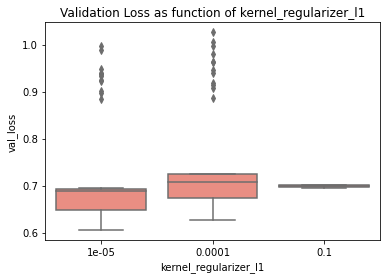

In [61]:
metric = 'kernel_regularizer_l1'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of kernel_regularizer_l2')

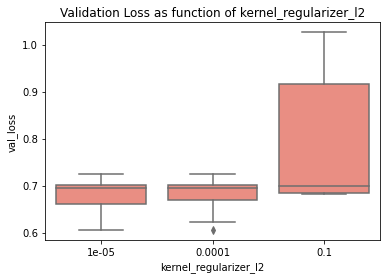

In [62]:
metric = 'kernel_regularizer_l2'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

(0.6, 0.7)

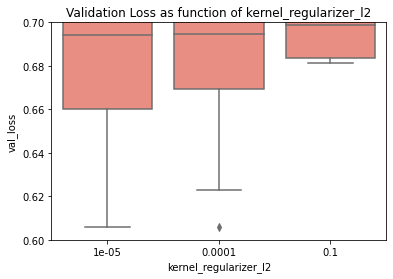

In [74]:
metric = 'kernel_regularizer_l2'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')
plt.ylim(0.6,0.7)

Text(0.5, 1.0, 'Validation Loss as function of bias_regularizer')

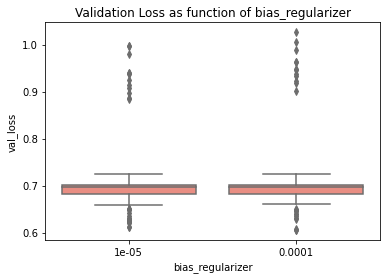

In [63]:
metric = 'bias_regularizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


(0.6, 0.7)

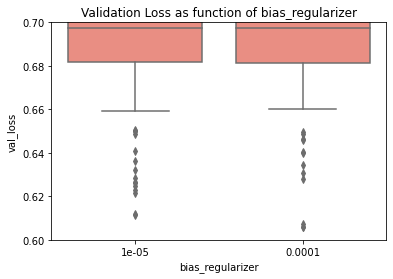

In [73]:
metric = 'bias_regularizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')
plt.ylim(0.6,0.7)

## 5.5 activity

Text(0.5, 1.0, 'Validation Loss as function of activity_regularizer')

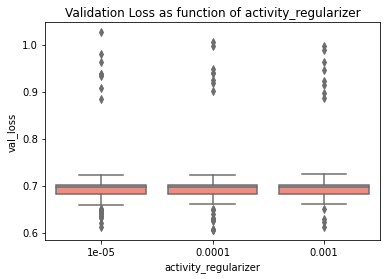

In [65]:
metric = 'activity_regularizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

(0.6, 0.7)

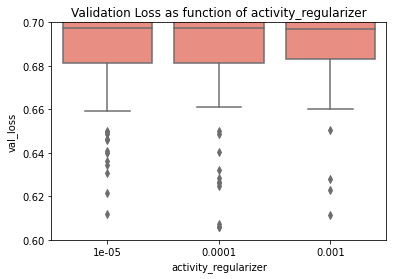

In [69]:
metric = 'activity_regularizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')
plt.ylim(0.6, 0.7)

(0.6, 0.8)

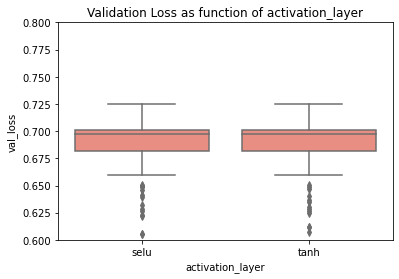

In [77]:
metric = 'activation_layer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')
plt.ylim(0.6, 0.8)

(0.6, 0.7)

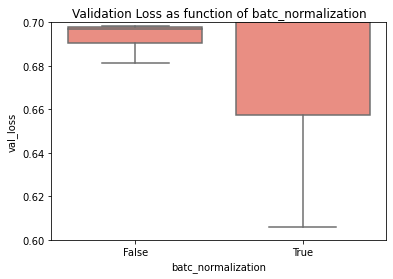

In [76]:
metric = 'batc_normalization'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')
plt.ylim(0.6, 0.7)

## Part 6

In [80]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[3],   #Done

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [64], #Done

    'lr':[0.001],#Done (?)
    
    'kernel_regularizer_l1':[0.00001,0.000001,0.0000001],
    'kernel_regularizer_l2':[0.00001,0.000001,0.0000001],
    'bias_regularizer':[0.0001],#Done
    'activity_regularizer':[0.0001],#Done

    #'dropout': [0,0.1,0.2,0.3,0.4],
    'dropout': [0],
    
  
    'kernel_initializer': ['uniform'],#Done

    'activation_layer':['tanh','selu'],
 
    'batc_normalization':[False,True],
 
}

In [81]:

t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy T - Weighted binary cross-entropy (softmax)')


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


  3%|██▎                                                                                | 1/36 [00:03<02:18,  3.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-06, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


  6%|████▌                                                                              | 2/36 [00:07<02:15,  3.98s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-07, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


  8%|██████▉                                                                            | 3/36 [00:11<02:09,  3.93s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 11%|█████████▏                                                                         | 4/36 [00:15<02:01,  3.79s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-06, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 14%|███████████▌                                                                       | 5/36 [00:19<02:00,  3.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-07, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 17%|█████████████▊                                                                     | 6/36 [00:23<01:56,  3.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-07, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 19%|████████████████▏                                                                  | 7/36 [00:27<01:52,  3.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-07, 'kernel_regularizer_l2': 1e-06, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 22%|██████████████████▍                                                                | 8/36 [00:30<01:46,  3.81s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-07, 'kernel_regularizer_l2': 1e-07, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 25%|████████████████████▊                                                              | 9/36 [00:34<01:45,  3.92s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 28%|██████████████████████▊                                                           | 10/36 [00:42<02:13,  5.14s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-06, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 31%|█████████████████████████                                                         | 11/36 [00:52<02:40,  6.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-07, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 33%|███████████████████████████▎                                                      | 12/36 [00:59<02:42,  6.75s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 36%|█████████████████████████████▌                                                    | 13/36 [01:07<02:40,  6.97s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-06, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 39%|███████████████████████████████▉                                                  | 14/36 [01:14<02:36,  7.12s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-07, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 42%|██████████████████████████████████▏                                               | 15/36 [01:23<02:41,  7.68s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-07, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 44%|████████████████████████████████████▍                                             | 16/36 [01:31<02:34,  7.74s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-07, 'kernel_regularizer_l2': 1e-06, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 47%|██████████████████████████████████████▋                                           | 17/36 [01:38<02:25,  7.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-07, 'kernel_regularizer_l2': 1e-07, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 50%|█████████████████████████████████████████                                         | 18/36 [01:47<02:24,  8.04s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 53%|███████████████████████████████████████████▎                                      | 19/36 [01:51<01:54,  6.76s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-06, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 56%|█████████████████████████████████████████████▌                                    | 20/36 [01:55<01:33,  5.84s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-07, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 58%|███████████████████████████████████████████████▊                                  | 21/36 [01:59<01:18,  5.26s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 61%|██████████████████████████████████████████████████                                | 22/36 [02:03<01:08,  4.87s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-06, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 64%|████████████████████████████████████████████████████▍                             | 23/36 [02:07<00:59,  4.57s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-07, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 67%|██████████████████████████████████████████████████████▋                           | 24/36 [02:11<00:52,  4.38s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-07, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 69%|████████████████████████████████████████████████████████▉                         | 25/36 [02:14<00:46,  4.18s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-07, 'kernel_regularizer_l2': 1e-06, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 72%|███████████████████████████████████████████████████████████▏                      | 26/36 [02:18<00:41,  4.13s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-07, 'kernel_regularizer_l2': 1e-07, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 75%|█████████████████████████████████████████████████████████████▌                    | 27/36 [02:22<00:36,  4.09s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 78%|███████████████████████████████████████████████████████████████▊                  | 28/36 [02:31<00:43,  5.45s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-06, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 81%|██████████████████████████████████████████████████████████████████                | 29/36 [02:41<00:48,  6.90s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-05, 'kernel_regularizer_l2': 1e-07, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 83%|████████████████████████████████████████████████████████████████████▎             | 30/36 [02:49<00:43,  7.27s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 86%|██████████████████████████████████████████████████████████████████████▌           | 31/36 [02:58<00:38,  7.61s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-06, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 89%|████████████████████████████████████████████████████████████████████████▉         | 32/36 [03:04<00:29,  7.36s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-07, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 92%|███████████████████████████████████████████████████████████████████████████▏      | 33/36 [03:12<00:22,  7.37s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-07, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 94%|█████████████████████████████████████████████████████████████████████████████▍    | 34/36 [03:20<00:14,  7.49s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-07, 'kernel_regularizer_l2': 1e-06, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 35/36 [03:29<00:08,  8.12s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-07, 'kernel_regularizer_l2': 1e-07, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [03:39<00:00,  6.09s/it]


In [82]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/T/Predykcja klasy T - Weighted binary cross-entropy (softmax)/051022213813.csv')

In [83]:
df=df.sort_values('val_loss',ascending=True)

In [84]:
df

,round_epochs,loss,fbeta_score,val_loss,val_fbeta_score,activation_layer,activity_regularizer,batc_normalization,batch_size,bias_regularizer,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
30,119,0.455790,[0.7834483 0.5791045 0.74358976],0.602989,[0.7363184 0.3448276 0.55284554],selu,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,1.000000e-06,1.000000e-05,sigmoid,0.001
34,139,0.431280,[0.7478754 0.601227 0.75 ],0.606752,[0.70454544 0.26190475 0.5409836 ],selu,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,1.000000e-07,1.000000e-06,sigmoid,0.001
29,118,0.459298,[0.78 0.589404 0.7908746],0.607775,[0.7032967 0.21875 0.6323529],selu,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,1.000000e-05,1.000000e-07,sigmoid,0.001
14,146,0.435728,[0.7711864 0.58507466 0.72989684],0.612712,[0.70157063 0.2647059 0.5203252 ],tanh,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,1.000000e-06,1.000000e-07,sigmoid,0.001
17,139,0.443510,[0.7705382 0.59756094 0.7611336 ],0.617971,[0.6931818 0.32500002 0.5873016 ],tanh,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,1.000000e-07,1.000000e-07,sigmoid,0.001
15,113,0.466099,[0.75455827 0.55727553 0.7276423 ],0.623791,[0.6961326 0.32500002 0.5123967 ],tanh,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,1.000000e-07,1.000000e-05,sigmoid,0.001
27,125,0.436483,[0.78055555 0.6149068 0.7613169 ],0.626052,[0.74489796 0.28571427 0.5203252 ],selu,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,1.000000e-05,1.000000e-05,sigmoid,0.001
10,147,0.398572,[0.8286517 0.6111111 0.80894303],0.627108,[0.6984127 0.30769232 0.56250006],tanh,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,1.000000e-05,1.000000e-06,sigmoid,0.001
13,108,0.487426,[0.7219796 0.56811595 0.72177416],0.632810,[0.6590909 0.27499998 0.53968257],tanh,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,1.000000e-06,1.000000e-06,sigmoid,0.001
12,103,0.475075,[0.7474748 0.57988167 0.7444668 ],0.635259,[0.69148934 0.25641027 0.4827586 ],tanh,0.0001,True,64,0.0001,0,100000,55,3,50,uniform,1.000000e-06,1.000000e-05,sigmoid,0.001


In [ ]:

    'kernel_regularizer_l1':[0.000001],
    'kernel_regularizer_l2':[0.00001,0.000001,0.0000001],
    

    'activation_layer':['tanh','selu'],
 
    'batc_normalization':[False,True],
 
}

Text(0.5, 1.0, 'Validation Loss as function of kernel_regularizer_l1')

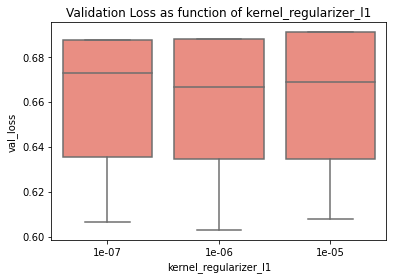

In [85]:
metric = 'kernel_regularizer_l1'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of kernel_regularizer_l2')

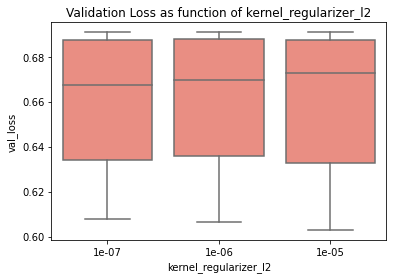

In [86]:
metric = 'kernel_regularizer_l2'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of activation_layer')

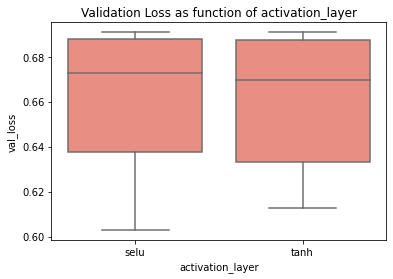

In [88]:
metric = 'activation_layer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of batc_normalization')

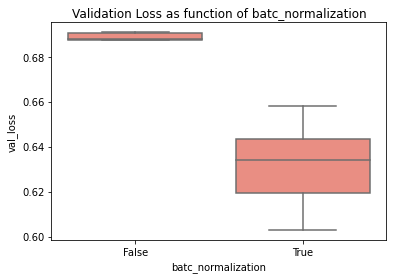

In [89]:
metric = 'batc_normalization'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

## Part 5

In [90]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[3,6],   #Done

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [64], #Done

    'lr':[0.001],
    
    'kernel_regularizer_l1':[0.000001],#Done
    'kernel_regularizer_l2':[0.00001],#Done
    'bias_regularizer':[0.0001],#Done
    'activity_regularizer':[0.0001],#Done

    'dropout': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    
  
    'kernel_initializer': ['uniform'],#Done

    'activation_layer':['tanh'],#Done
 
    'batc_normalization':[True],#Done
 
}

In [91]:

t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy T - Weighted binary cross-entropy (softmax)')


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


  2%|██                                                                                 | 1/40 [00:10<06:59, 10.75s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


  5%|████▏                                                                              | 2/40 [00:22<07:17, 11.52s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence thi


  8%|██████▏                                                                            | 3/40 [00:34<07:15, 11.78s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence thi


 10%|████████▎                                                                          | 4/40 [00:47<07:11, 11.98s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 12%|██████████▍                                                                        | 5/40 [01:00<07:18, 12.53s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 15%|████████████▍                                                                      | 6/40 [01:15<07:28, 13.18s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 18%|██████████████▌                                                                    | 7/40 [01:33<08:07, 14.78s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 20%|████████████████▌                                                                  | 8/40 [01:52<08:35, 16.10s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 22%|██████████████████▋                                                                | 9/40 [02:08<08:21, 16.19s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 25%|████████████████████▌                                                             | 10/40 [02:26<08:26, 16.87s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 28%|██████████████████████▌                                                           | 11/40 [02:46<08:29, 17.56s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 30%|████████████████████████▌                                                         | 12/40 [03:10<09:11, 19.71s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 32%|██████████████████████████▋                                                       | 13/40 [03:25<08:16, 18.38s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 35%|████████████████████████████▋                                                     | 14/40 [03:44<07:57, 18.37s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 38%|██████████████████████████████▊                                                   | 15/40 [04:01<07:32, 18.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 40%|████████████████████████████████▊                                                 | 16/40 [04:10<06:03, 15.15s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 42%|██████████████████████████████████▊                                               | 17/40 [04:28<06:11, 16.14s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 45%|████████████████████████████████████▉                                             | 18/40 [04:42<05:42, 15.55s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 48%|██████████████████████████████████████▉                                           | 19/40 [04:52<04:52, 13.92s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 50%|█████████████████████████████████████████                                         | 20/40 [05:03<04:17, 12.88s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.5, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 52%|███████████████████████████████████████████                                       | 21/40 [05:14<03:53, 12.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.5, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 55%|█████████████████████████████████████████████                                     | 22/40 [05:24<03:32, 11.78s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.5, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 57%|███████████████████████████████████████████████▏                                  | 23/40 [05:34<03:10, 11.23s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.5, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 60%|█████████████████████████████████████████████████▏                                | 24/40 [05:43<02:49, 10.58s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.6, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 62%|███████████████████████████████████████████████████▎                              | 25/40 [05:55<02:44, 10.99s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.6, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [06:05<02:29, 10.68s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.6, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [06:15<02:16, 10.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.6, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [06:28<02:12, 11.02s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.7, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [06:34<01:44,  9.54s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.7, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [06:41<01:29,  8.93s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.7, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [06:51<01:22,  9.15s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.7, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [07:02<01:16,  9.62s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.8, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [07:09<01:01,  8.84s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.8, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [07:14<00:47,  7.91s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.8, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [07:22<00:39,  7.93s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.8, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [07:33<00:35,  8.86s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.9, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [07:39<00:23,  7.91s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.9, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [07:45<00:14,  7.22s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.9, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [07:52<00:07,  7.40s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.9, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 6, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [08:00<00:00, 12.01s/it]


In [96]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/T/Predykcja klasy T - Weighted binary cross-entropy (softmax)/051022214536.csv')

In [97]:

df=df.sort_values('val_loss',ascending=True)

In [98]:
df

,round_epochs,loss,fbeta_score,val_loss,val_fbeta_score,activation_layer,activity_regularizer,batc_normalization,batch_size,bias_regularizer,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
13,302,0.553516,[0.7125505 0.46052635 0.5962733 ],0.582247,[0.74038464 0.32142854 0.5423729 ],tanh,0.0001,True,64,0.0001,0.3,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
6,158,0.524369,[0.68914956 0.48396504 0.6560636 ],0.590320,[0.7071823 0.2631579 0.576 ],tanh,0.0001,True,64,0.0001,0.1,100000,55,6,50,uniform,0.000001,0.00001,sigmoid,0.001
12,236,0.587707,[0.6647888 0.41139242 0.5936255 ],0.592761,[0.7179488 0.2857143 0.5190839],tanh,0.0001,True,64,0.0001,0.3,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
9,294,0.506819,[0.6978022 0.50491804 0.6707071 ],0.593632,[0.74111676 0.2962963 0.56488556],tanh,0.0001,True,64,0.0001,0.2,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
8,230,0.539934,[0.6725926 0.44864866 0.6335404 ],0.594149,[0.6666667 0.26086956 0.59016395],tanh,0.0001,True,64,0.0001,0.2,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
5,161,0.510376,[0.7238913 0.49707603 0.6776181 ],0.596518,[0.7150259 0.30555555 0.5128205 ],tanh,0.0001,True,64,0.0001,0.1,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
4,171,0.514692,[0.6948905 0.48850572 0.6545454 ],0.600361,[0.74999994 0.28571427 0.56296295],tanh,0.0001,True,64,0.0001,0.1,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
10,216,0.594077,[0.6407507 0.47588426 0.50106156],0.600444,[0.7339449 0.4 0.47706422],tanh,0.0001,True,64,0.0001,0.2,100000,55,6,50,uniform,0.000001,0.00001,sigmoid,0.001
16,304,0.618160,[0.71372545 0.34020618 0.57644993],0.604975,[0.77227724 0.2631579 0.57746476],tanh,0.0001,True,64,0.0001,0.4,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
1,152,0.429256,[0.7681564 0.62295085 0.78500986],0.606845,[0.7179488 0.41095892 0.50877196],tanh,0.0001,True,64,0.0001,0.0,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001


Text(0.5, 1.0, 'Validation Loss as function of dropout')

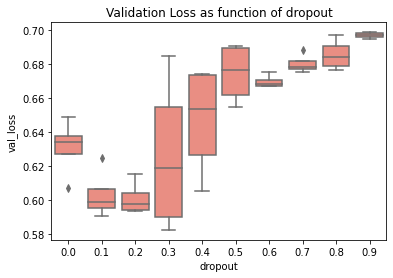

In [100]:
metric = 'dropout'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of hidden_layers')

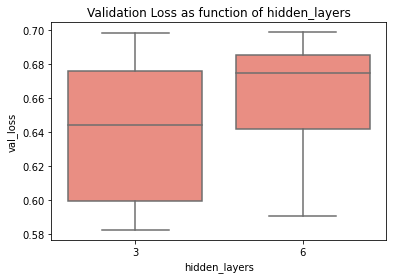

In [101]:
metric = 'hidden_layers'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

## Part 6

In [102]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[3],   #Done

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [64], #Done

    'lr':[0.001,0.0001,0.00001],
    
    'kernel_regularizer_l1':[0.000001],#Done
    'kernel_regularizer_l2':[0.00001],#Done
    'bias_regularizer':[0.0001],#Done
    'activity_regularizer':[0.0001],#Done

    'dropout': [0,0.1,0.2,0.3],
    
  
    'kernel_initializer': ['uniform'],#Done

    'activation_layer':['tanh'],#Done
 
    'batc_normalization':[True,False],#Done
 
}

In [103]:

t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy T - Weighted binary cross-entropy (softmax)')


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


  4%|███▍                                                                               | 1/24 [00:08<03:04,  8.00s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


  8%|██████▉                                                                            | 2/24 [00:13<02:22,  6.46s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.aut


 12%|██████████▍                                                                        | 3/24 [00:18<02:05,  6.00s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 17%|█████████████▊                                                                     | 4/24 [00:32<03:01,  9.09s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.


 21%|█████████████████▎                                                                 | 5/24 [00:40<02:46,  8.78s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 25%|████████████████████▊                                                              | 6/24 [00:46<02:19,  7.75s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 29%|████████████████████████▏                                                          | 7/24 [01:02<02:56, 10.38s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.


 33%|███████████████████████████▋                                                       | 8/24 [01:09<02:29,  9.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 38%|███████████████████████████████▏                                                   | 9/24 [01:15<02:02,  8.18s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 42%|██████████████████████████████████▏                                               | 10/24 [01:34<02:42, 11.63s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.


 46%|█████████████████████████████████████▌                                            | 11/24 [01:40<02:08,  9.91s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 50%|█████████████████████████████████████████                                         | 12/24 [01:47<01:47,  8.92s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 54%|████████████████████████████████████████████▍                                     | 13/24 [01:52<01:25,  7.73s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 58%|███████████████████████████████████████████████▊                                  | 14/24 [01:56<01:06,  6.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.au


 62%|███████████████████████████████████████████████████▎                              | 15/24 [02:00<00:53,  5.94s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [02:05<00:44,  5.55s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf


 71%|██████████████████████████████████████████████████████████                        | 17/24 [02:10<00:38,  5.46s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [02:15<00:31,  5.24s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [02:19<00:25,  5.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [02:25<00:20,  5.19s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [02:30<00:15,  5.17s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [02:35<00:10,  5.07s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.0001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [02:39<00:04,  4.85s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 1e-05}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:43<00:00,  6.83s/it]


In [104]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/T/Predykcja klasy T - Weighted binary cross-entropy (softmax)/051022215718.csv')

In [105]:

df=df.sort_values('val_loss',ascending=True)

In [106]:
df

,round_epochs,loss,fbeta_score,val_loss,val_fbeta_score,activation_layer,activity_regularizer,batc_normalization,batch_size,bias_regularizer,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
9,313,0.542596,[0.6311239 0.44574782 0.62068963],0.581670,[0.7216495 0.3928571 0.6060606],tanh,0.0001,True,64,0.0001,0.3,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.00100
3,197,0.478695,[0.7204611 0.51810586 0.711579 ],0.595548,[0.6989247 0.27160493 0.59130436],tanh,0.0001,True,64,0.0001,0.1,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.00100
6,237,0.533664,[0.6647145 0.43915343 0.6081371 ],0.612575,[0.73846155 0.3157895 0.5405406 ],tanh,0.0001,True,64,0.0001,0.2,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.00100
0,107,0.476207,[0.7733711 0.57313436 0.69815195],0.649659,[0.6380368 0.24242425 0.5166667 ],tanh,0.0001,True,64,0.0001,0.0,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.00100
4,98,0.693698,[0.4992658 0.22429909 0.3954373 ],0.679700,[0.6344086 0.30508474 0.49635035],tanh,0.0001,True,64,0.0001,0.1,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.00010
7,79,0.695831,[0.45588234 0.1882353 0.3661417 ],0.681197,[0.595122 0.2 0.3649635],tanh,0.0001,True,64,0.0001,0.2,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.00010
1,51,0.686544,[0.46085674 0.29120877 0.34086242],0.686683,[0.60098517 0.22916666 0.26506025],tanh,0.0001,True,64,0.0001,0.0,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.00010
15,51,0.687644,[0.17391303 0.21368949 0.33035713],0.687622,[0. 0.2121212 0.2682927],tanh,0.0001,False,64,0.0001,0.1,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.00100
18,51,0.687727,[0.20841685 0.25454545 0.14649682],0.687736,[0.01960784 0.24186045 0. ],tanh,0.0001,False,64,0.0001,0.2,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.00100
21,51,0.687783,[0.02463054 0.24292454 0.04379562],0.687811,[0. 0.24770641 0. ],tanh,0.0001,False,64,0.0001,0.3,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.00100


In [111]:
df.iloc[0]

round_epochs                                            313
loss                                               0.542596
fbeta_score              [0.6311239  0.44574782 0.62068963]
val_loss                                            0.58167
val_fbeta_score             [0.7216495 0.3928571 0.6060606]
activation_layer                                       tanh
activity_regularizer                                 0.0001
batc_normalization                                     True
batch_size                                               64
bias_regularizer                                     0.0001
dropout                                                 0.3
epochs                                               100000
first_neuron                                             55
hidden_layers                                             3
hidden_neuron                                            50
kernel_initializer                                  uniform
kernel_regularizer_l1                   

In [ ]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[3],   #Done

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [64], #Done

    'lr':[0.001,0.0001,0.00001],
    
    'kernel_regularizer_l1':[0.000001],#Done
    'kernel_regularizer_l2':[0.00001],#Done
    'bias_regularizer':[0.0001],#Done
    'activity_regularizer':[0.0001],#Done

    'dropout': [0,0.1,0.2,0.3],
    
  
    'kernel_initializer': ['uniform'],#Done

    'activation_layer':['tanh'],#Done
 
    'batc_normalization':[True,False],#Done
 
}

Text(0.5, 1.0, 'Validation Loss as function of lr')

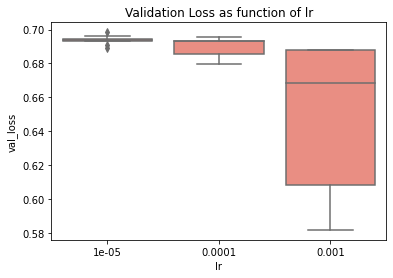

In [107]:
metric = 'lr'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

Text(0.5, 1.0, 'Validation Loss as function of dropout')

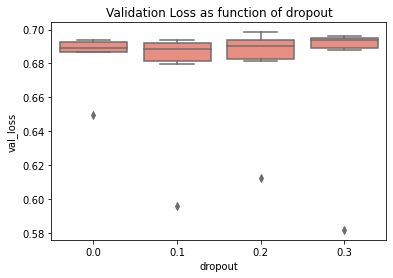

In [108]:
metric = 'dropout'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

(0.65, 0.7)

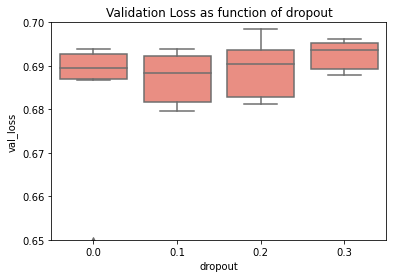

In [114]:
metric = 'dropout'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')
ax.set_ylim(0.65,0.7)

Text(0.5, 1.0, 'Validation Loss as function of batc_normalization')

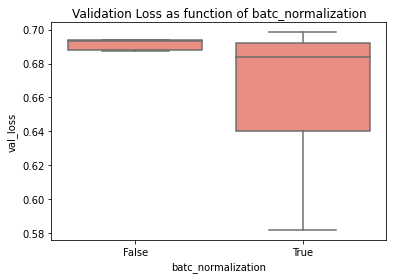

In [109]:
metric = 'batc_normalization'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')

In [115]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[3],   #Done

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [64], #Done

    'lr':[0.001],
    
    'kernel_regularizer_l1':[0.000001],#Done
    'kernel_regularizer_l2':[0.00001],#Done
    'bias_regularizer':[0.0001],#Done
    'activity_regularizer':[0.0001],#Done

    'dropout': [0.1,0.3],
    
  
    'kernel_initializer': ['uniform'],#Done

    'activation_layer':['tanh'],#Done
 
    'batc_normalization':[True],#Done
 
}

In [116]:

t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy T - Weighted binary cross-entropy (softmax)')


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


 50%|██████████████████████████████████████████                                          | 1/2 [00:12<00:12, 12.85s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:30<00:00, 15.18s/it]


In [117]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/T/Predykcja klasy T - Weighted binary cross-entropy (softmax)/051022220423.csv')

In [118]:

df=df.sort_values('val_loss',ascending=True)

In [119]:
df

,round_epochs,loss,fbeta_score,val_loss,val_fbeta_score,activation_layer,activity_regularizer,batc_normalization,batch_size,bias_regularizer,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
0,174,0.508595,[0.71692747 0.4809384 0.6859504 ],0.593438,[0.7329843 0.26865673 0.516129 ],tanh,0.0001,True,64,0.0001,0.1,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
1,261,0.554234,[0.6703601 0.4471299 0.5978948],0.604637,[0.7173913 0.3448276 0.5765766],tanh,0.0001,True,64,0.0001,0.3,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001


In [ ]:
## Staty finalowej sieci neuro

In [112]:
df.iloc[0]

round_epochs                                            313
loss                                               0.542596
fbeta_score              [0.6311239  0.44574782 0.62068963]
val_loss                                            0.58167
val_fbeta_score             [0.7216495 0.3928571 0.6060606]
activation_layer                                       tanh
activity_regularizer                                 0.0001
batc_normalization                                     True
batch_size                                               64
bias_regularizer                                     0.0001
dropout                                                 0.3
epochs                                               100000
first_neuron                                             55
hidden_layers                                             3
hidden_neuron                                            50
kernel_initializer                                  uniform
kernel_regularizer_l1                   

In [ ]:
# Ostatnie podejscie - rozne dr

In [117]:
dr_rate=[]
for x in range(0,101):
    dr_rate.append(x*0.01)

In [118]:
dr_rate

[0.0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35000000000000003,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41000000000000003,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47000000000000003,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.5700000000000001,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.6900000000000001,
 0.7000000000000001,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.8200000000000001,
 0.8300000000000001,
 0.84,
 0.85,
 0.86,
 0.87,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.9400000000000001,
 0.9500000000000001,
 0.96,
 0.97,
 0.98,
 0.99,
 1.0]

In [119]:
p = {
    'first_neuron':[55],  #Done
     'hidden_neuron':[50], #Done

     'hidden_layers':[3],   #Done

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [64], #Done

    'lr':[0.001],
    
    'kernel_regularizer_l1':[0.000001],#Done
    'kernel_regularizer_l2':[0.00001],#Done
    'bias_regularizer':[0.0001],#Done
    'activity_regularizer':[0.0001],#Done

    'dropout': dr_rate,
    
  
    'kernel_initializer': ['uniform'],#Done

    'activation_layer':['tanh'],#Done
 
    'batc_normalization':[True],#Done
 
}

In [120]:

def numerai_model(x_train, y_train, x_val, y_val, params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(3, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adagrad(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=3,beta=1.0)])
    
  
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        class_weight={0 : 0.64147775,
                                      1 : 2.42539683,
                                      2 : 0.97201018},
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=1,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )

    return history, model

In [121]:

t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy T - Weighted binary cross-entropy (softmax)')

  0%|                                                                                          | 0/101 [00:00<?, ?it/s]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

  1%|▊                                                                                 | 1/101 [00:19<32:33, 19.53s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.01, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

  2%|█▌                                                                                | 2/101 [00:41<34:44, 21.05s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.02, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

  3%|██▍                                                                               | 3/101 [01:06<36:57, 22.62s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.03, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

  4%|███▏                                                                              | 4/101 [01:32<39:02, 24.15s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.04, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

  5%|████                                                                              | 5/101 [01:59<40:29, 25.30s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.05, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

  6%|████▊                                                                             | 6/101 [02:29<42:13, 26.66s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.06, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

  7%|█████▋                                                                            | 7/101 [02:55<41:22, 26.41s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.07, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

  8%|██████▍                                                                           | 8/101 [03:21<40:46, 26.31s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.08, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

  9%|███████▎                                                                          | 9/101 [03:54<43:29, 28.36s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.09, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 10%|████████                                                                         | 10/101 [04:18<40:57, 27.01s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.1, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 11%|████████▊                                                                        | 11/101 [04:42<39:16, 26.19s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.11, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 12%|█████████▌                                                                       | 12/101 [05:09<39:19, 26.52s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.12, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 13%|██████████▍                                                                      | 13/101 [05:40<40:43, 27.77s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.13, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 14%|███████████▏                                                                     | 14/101 [06:09<41:00, 28.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.14, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 15%|████████████                                                                     | 15/101 [06:36<39:58, 27.89s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.15, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 16%|████████████▊                                                                    | 16/101 [07:06<40:07, 28.33s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.16, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 17%|█████████████▋                                                                   | 17/101 [07:30<38:02, 27.17s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.17, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 18%|██████████████▍                                                                  | 18/101 [08:00<38:37, 27.92s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.18, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 19%|███████████████▏                                                                 | 19/101 [08:30<39:05, 28.60s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.19, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 20%|████████████████                                                                 | 20/101 [08:57<37:56, 28.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.2, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 21%|████████████████▊                                                                | 21/101 [09:28<38:39, 28.99s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.21, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 22%|█████████████████▋                                                               | 22/101 [09:58<38:43, 29.41s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.22, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 23%|██████████████████▍                                                              | 23/101 [10:30<39:02, 30.04s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.23, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 24%|███████████████████▏                                                             | 24/101 [10:57<37:28, 29.21s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.24, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 25%|████████████████████                                                             | 25/101 [11:31<38:47, 30.63s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.25, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 26%|████████████████████▊                                                            | 26/101 [12:00<37:34, 30.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.26, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 27%|█████████████████████▋                                                           | 27/101 [12:27<36:05, 29.26s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.27, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 28%|██████████████████████▍                                                          | 28/101 [12:58<36:13, 29.77s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.28, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 29%|███████████████████████▎                                                         | 29/101 [13:27<35:28, 29.57s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.29, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 30%|████████████████████████                                                         | 30/101 [13:55<34:22, 29.05s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.3, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 31%|████████████████████████▊                                                        | 31/101 [14:29<35:29, 30.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.31, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 32%|█████████████████████████▋                                                       | 32/101 [15:03<36:28, 31.72s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.32, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 33%|██████████████████████████▍                                                      | 33/101 [15:39<37:13, 32.84s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.33, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 34%|███████████████████████████▎                                                     | 34/101 [16:12<36:49, 32.99s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.34, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 35%|████████████████████████████                                                     | 35/101 [16:47<36:58, 33.61s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.35000000000000003, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the fun

 36%|████████████████████████████▊                                                    | 36/101 [17:20<35:57, 33.19s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.36, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 37%|█████████████████████████████▋                                                   | 37/101 [17:47<33:26, 31.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.37, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 38%|██████████████████████████████▍                                                  | 38/101 [18:22<34:17, 32.66s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.38, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 39%|███████████████████████████████▎                                                 | 39/101 [18:57<34:31, 33.42s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.39, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 40%|████████████████████████████████                                                 | 40/101 [19:25<32:13, 31.69s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.4, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 41%|████████████████████████████████▉                                                | 41/101 [19:51<29:51, 29.85s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.41000000000000003, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the fun

 42%|█████████████████████████████████▋                                               | 42/101 [20:24<30:24, 30.92s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.42, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 43%|██████████████████████████████████▍                                              | 43/101 [20:57<30:34, 31.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.43, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 44%|███████████████████████████████████▎                                             | 44/101 [21:29<30:02, 31.63s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.44, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 45%|████████████████████████████████████                                             | 45/101 [21:57<28:26, 30.47s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.45, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 46%|████████████████████████████████████▉                                            | 46/101 [22:25<27:24, 29.90s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.46, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 47%|█████████████████████████████████████▋                                           | 47/101 [22:54<26:28, 29.41s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.47000000000000003, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the fun

 48%|██████████████████████████████████████▍                                          | 48/101 [23:03<20:45, 23.50s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.48, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 49%|███████████████████████████████████████▎                                         | 49/101 [23:38<23:19, 26.92s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.49, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 50%|████████████████████████████████████████                                         | 50/101 [24:11<24:26, 28.75s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.5, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 50%|████████████████████████████████████████▉                                        | 51/101 [24:47<25:41, 30.84s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.51, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 51%|█████████████████████████████████████████▋                                       | 52/101 [25:16<24:44, 30.29s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.52, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 52%|██████████████████████████████████████████▌                                      | 53/101 [25:23<18:40, 23.34s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.53, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 53%|███████████████████████████████████████████▎                                     | 54/101 [25:42<17:09, 21.90s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.54, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 54%|████████████████████████████████████████████                                     | 55/101 [25:54<14:36, 19.05s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.55, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 55%|████████████████████████████████████████████▉                                    | 56/101 [26:04<12:12, 16.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.56, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 56%|█████████████████████████████████████████████▋                                   | 57/101 [26:12<10:07, 13.80s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.5700000000000001, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the func

 57%|██████████████████████████████████████████████▌                                  | 58/101 [26:20<08:44, 12.19s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.58, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 58%|███████████████████████████████████████████████▎                                 | 59/101 [26:29<07:42, 11.00s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.59, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 59%|████████████████████████████████████████████████                                 | 60/101 [26:37<07:01, 10.27s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.6, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 60%|████████████████████████████████████████████████▉                                | 61/101 [26:44<06:14,  9.36s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.61, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 61%|█████████████████████████████████████████████████▋                               | 62/101 [26:53<05:58,  9.18s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.62, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 62%|██████████████████████████████████████████████████▌                              | 63/101 [27:01<05:31,  8.73s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.63, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 63%|███████████████████████████████████████████████████▎                             | 64/101 [27:09<05:16,  8.55s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.64, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 64%|████████████████████████████████████████████████████▏                            | 65/101 [27:16<04:52,  8.11s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.65, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 65%|████████████████████████████████████████████████████▉                            | 66/101 [27:24<04:39,  8.00s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.66, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 66%|█████████████████████████████████████████████████████▋                           | 67/101 [27:32<04:39,  8.23s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.67, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 67%|██████████████████████████████████████████████████████▌                          | 68/101 [27:39<04:17,  7.81s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.68, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 68%|███████████████████████████████████████████████████████▎                         | 69/101 [27:48<04:16,  8.00s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.6900000000000001, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the func

 69%|████████████████████████████████████████████████████████▏                        | 70/101 [27:56<04:09,  8.06s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.7000000000000001, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the func

 70%|████████████████████████████████████████████████████████▉                        | 71/101 [28:02<03:47,  7.57s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.71, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 71%|█████████████████████████████████████████████████████████▋                       | 72/101 [28:09<03:32,  7.32s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.72, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 72%|██████████████████████████████████████████████████████████▌                      | 73/101 [28:19<03:43,  7.98s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.73, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 73%|███████████████████████████████████████████████████████████▎                     | 74/101 [28:26<03:32,  7.88s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.74, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 74%|████████████████████████████████████████████████████████████▏                    | 75/101 [28:34<03:26,  7.96s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.75, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [28:41<03:08,  7.55s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.76, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 76%|█████████████████████████████████████████████████████████████▊                   | 77/101 [28:48<02:54,  7.28s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.77, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 77%|██████████████████████████████████████████████████████████████▌                  | 78/101 [28:53<02:34,  6.72s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.78, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 78%|███████████████████████████████████████████████████████████████▎                 | 79/101 [29:01<02:38,  7.19s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.79, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 79%|████████████████████████████████████████████████████████████████▏                | 80/101 [29:08<02:29,  7.12s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.8, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 80%|████████████████████████████████████████████████████████████████▉                | 81/101 [29:15<02:22,  7.12s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.81, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 81%|█████████████████████████████████████████████████████████████████▊               | 82/101 [29:22<02:13,  7.04s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.8200000000000001, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the func

 82%|██████████████████████████████████████████████████████████████████▌              | 83/101 [29:29<02:03,  6.85s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.8300000000000001, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the func

 83%|███████████████████████████████████████████████████████████████████▎             | 84/101 [29:35<01:53,  6.67s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.84, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 84%|████████████████████████████████████████████████████████████████████▏            | 85/101 [29:41<01:44,  6.54s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.85, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 85%|████████████████████████████████████████████████████████████████████▉            | 86/101 [29:49<01:43,  6.88s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.86, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 86%|█████████████████████████████████████████████████████████████████████▊           | 87/101 [29:55<01:33,  6.69s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.87, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 87%|██████████████████████████████████████████████████████████████████████▌          | 88/101 [30:02<01:27,  6.73s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.88, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 88%|███████████████████████████████████████████████████████████████████████▍         | 89/101 [30:07<01:15,  6.27s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.89, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 89%|████████████████████████████████████████████████████████████████████████▏        | 90/101 [30:12<01:05,  5.98s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.9, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

 90%|████████████████████████████████████████████████████████████████████████▉        | 91/101 [30:18<00:57,  5.75s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.91, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 91%|█████████████████████████████████████████████████████████████████████████▊       | 92/101 [30:23<00:50,  5.61s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.92, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 93/101 [30:28<00:44,  5.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.93, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 93%|███████████████████████████████████████████████████████████████████████████▍     | 94/101 [30:34<00:39,  5.64s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.9400000000000001, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the func

 94%|████████████████████████████████████████████████████████████████████████████▏    | 95/101 [30:39<00:33,  5.52s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.9500000000000001, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the func

 95%|████████████████████████████████████████████████████████████████████████████▉    | 96/101 [30:45<00:27,  5.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.96, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 97/101 [30:51<00:23,  5.81s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.97, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 98/101 [30:59<00:18,  6.29s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.98, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 99/101 [31:06<00:13,  6.56s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 0.99, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

 99%|███████████████████████████████████████████████████████████████████████████████▏| 100/101 [31:14<00:06,  6.88s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': True, 'batch_size': 64, 'bias_regularizer': 0.0001, 'dropout': 1.0, 'epochs': 100000, 'first_neuron': 55, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'last_activation': 'sigmoid', 'lr': 0.001}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ValueError: Exception encountered when calling layer "dropout" (type Dropout).

`rate` must be a scalar tensor or a float in the range [0, 1). Received: rate=1.0

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 55), dtype=float32)
  • training=True

In [122]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/T/Predykcja klasy T - Weighted binary cross-entropy (softmax)/051222131540.csv')

In [123]:

df=df.sort_values('val_loss',ascending=True)

In [124]:
df

,round_epochs,loss,fbeta_score,val_loss,val_fbeta_score,activation_layer,activity_regularizer,batc_normalization,batch_size,bias_regularizer,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
8,539,0.312565,[0.84648186 0.67455626 0.81072557],0.362793,[0.8497409 0.6557377 0.796875 ],tanh,0.0001,True,64,0.0001,0.08,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
4,465,0.288222,[0.86772484 0.7020649 0.8274761 ],0.363441,[0.83902436 0.69230765 0.768 ],tanh,0.0001,True,64,0.0001,0.04,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
3,448,0.283250,[0.87830687 0.7108433 0.83412325],0.374417,[0.84313726 0.7083333 0.8000001 ],tanh,0.0001,True,64,0.0001,0.03,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
5,489,0.307949,[0.8400435 0.70520234 0.8248062 ],0.380290,[0.82901555 0.73015875 0.7777778 ],tanh,0.0001,True,64,0.0001,0.05,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
2,404,0.284982,[0.86137563 0.72303206 0.84565926],0.380841,[0.83505154 0.6027397 0.81739134],tanh,0.0001,True,64,0.0001,0.02,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,51,0.713793,[0.34838712 0.18666665 0.3532847 ],0.687339,[0. 0. 0.5078125],tanh,0.0001,True,64,0.0001,0.89,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
94,51,0.737424,[0.40145105 0.16227181 0.2881356 ],0.688125,[0. 0.24770641 0. ],tanh,0.0001,True,64,0.0001,0.94,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
92,51,0.710347,[0.3710292 0.20366597 0.30696204],0.688449,[0.20979021 0.18390803 0. ],tanh,0.0001,True,64,0.0001,0.92,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001
90,51,0.709621,[0.36363637 0.21906693 0.30514097],0.688935,[0.6836364 0.23809524 0. ],tanh,0.0001,True,64,0.0001,0.90,100000,55,3,50,uniform,0.000001,0.00001,sigmoid,0.001


## Cross-walidacja NN klasy T!

# dr = 0.08

In [125]:
p = {
    'first_neuron':55,  #Done
     'hidden_neuron':50, #Done

     'hidden_layers':3,   #Done

     
    'epochs': 100000, # never touch it


    'last_activation': 'sigmoid', #never touch it


    'batch_size':64, #Done

    'lr':0.001,
    
    'kernel_regularizer_l1':0.000001,#Done
    'kernel_regularizer_l2':0.00001,#Done
    'bias_regularizer':0.0001,#Done
    'activity_regularizer':0.0001,#Done

    'dropout': 0.08,
    
  
    'kernel_initializer': 'uniform',#Done

    'activation_layer':'tanh',#Done
 
    'batc_normalization':True#Done
 
}

In [126]:

def numerai_model(x_train, y_train, x_val, y_val, params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(3, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adagrad(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=3,beta=1.0)])
    
  
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        class_weight={0 : 0.64147775,
                                      1 : 2.42539683,
                                      2 : 0.97201018},
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=1,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )

    return history, model

In [ ]:
Sprobowac zarowno na dropoucie 0,1 jak i 0.3 (0.1 raczj lepszy bo nizsze val_loss)

In [96]:
p = {
    'first_neuron':55,  #Done
     'hidden_neuron':50, #Done

     'hidden_layers':3,   #Done

     
    'epochs': 100000, # never touch it


    'last_activation': 'sigmoid', #never touch it


    'batch_size':64, #Done

    'lr':0.001,
    
    'kernel_regularizer_l1':0.000001,#Done
    'kernel_regularizer_l2':0.00001,#Done
    'bias_regularizer':0.0001,#Done
    'activity_regularizer':0.0001,#Done

    'dropout': 0.3,
    
  
    'kernel_initializer': 'uniform',#Done

    'activation_layer':'tanh',#Done
 
    'batc_normalization':True#Done
 
}

In [127]:

def numerai_model(x_train, y_train, x_val, y_val, params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(3, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adagrad(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=3,beta=1.0)])
    
  
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        class_weight={0 : 0.64147775,
                                      1 : 2.42539683,
                                      2 : 0.97201018},
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=1,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )

    return history, model

In [135]:

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
dane_do_zapisu=pd.DataFrame()
licznik=1

for train, test in kfold.split(caly_df,train_label_2): # train 80, test 20 %
    train, val = train_test_split(train, test_size=0.1, random_state=42) # train 80 % test 10% val 10 %
    
    returny=numerai_model(caly_df[train], caly_label[train], caly_df[val],caly_label[val], p)
    
    model=returny[1]
    # evaluate the model

    
    predictions = model.predict(caly_df[test])
    rezults=[]
    w_0=[]
    w_1=[]
    w_2=[]
    for z in predictions:
        rezults.append(np.argmax(z))
        w_0.append(z[0])
        w_1.append(z[1])
        w_2.append(z[2])
    


    scores=f1_score(train_label_2[test], rezults,average='macro')
    
    dane_folda=pd.DataFrame({"pred": list(rezults),
                                "obs": train_label_2[test].tolist(),
                                 "probability_0":list(w_0),
                                 "probability_1":list(w_1),
                                 "probability_2":list(w_2),
                                "Fold":licznik})
    
    dane_do_zapisu=pd.concat([dane_do_zapisu,dane_folda])
    cvscores.append(scores)
    licznik+=1
    
     

{'first_neuron': 55, 'hidden_neuron': 50, 'hidden_layers': 3, 'epochs': 100000, 'last_activation': 'sigmoid', 'batch_size': 64, 'lr': 0.001, 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'bias_regularizer': 0.0001, 'activity_regularizer': 0.0001, 'dropout': 0.08, 'kernel_initializer': 'uniform', 'activation_layer': 'tanh', 'batc_normalization': True}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model weights from the end of the best epoch: 1.
Epoch 00051: early stopping
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [136]:
cvscores

[0.4679096045197739,
 0.4600454112649235,
 0.5459252649794505,
 0.45139542996685855,
 0.17120622568093383]

In [137]:
sum(cvscores)/len(cvscores) #0.032977654217233775

0.41929638728238805

In [138]:
cf_matrix = confusion_matrix(dane_do_zapisu['obs'], dane_do_zapisu['pred'])

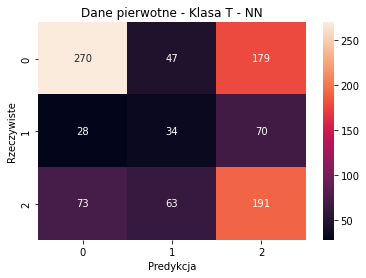

In [139]:

ax = plt.axes()
sns.heatmap(cf_matrix, annot=True, fmt='g')

ax.set_title('Dane pierwotne - Klasa T - NN')
plt.ylabel('Rzeczywiste')
plt.xlabel('Predykcja')
plt.show()


In [ ]:
precision = precision_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'],  average='macro')
recall = recall_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'],  average='macro')
f1score=f1_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'], average='macro')
print('Recall: %.3f' % recall)
print('Precision: %.3f' % precision)
print('F1score: %.3f' % f1score)

In [128]:
train_df=pd.read_csv("D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/Dane_do_uczenia_T.csv", encoding="utf-8")
del train_df['Unnamed: 0']
train_df['scale'].loc[(train_df['scale'] == 'T1')] = 0
train_df['scale'].loc[(train_df['scale'] == 'T2')] = 1
train_df['scale'].loc[(train_df['scale'] == 'T3')] = 2
train_label=train_df['scale']
del train_df['scale']
scaler = StandardScaler()
train_df=scaler.fit_transform(train_df)
train_label=np.asarray(train_label).astype(np.int)
train_label_2=train_label
encoder = LabelEncoder()
encoder.fit(train_label)
train_label = encoder.transform(train_label)
# convert integers to dummy variables (i.e. one hot encoded)

train_label = np_utils.to_categorical(train_label)

In [129]:
train_df

array([[-0.15545413, -0.19268726, -0.18007555, ..., -0.11325408,
        -0.1310684 , -0.14934876],
       [-0.1740803 , -0.20813705, -0.23130506, ..., -0.20152997,
        -0.17992108, -0.14934876],
       [-0.19408164, -0.21062068, -0.23130506, ..., -0.20152997,
        -0.17992108, -0.14934876],
       ...,
       [-0.21070965, -0.21834049, -0.23130506, ..., -0.20152997,
        -0.17992108, -0.14934876],
       [ 0.00099515, -0.02176597, -0.23130506, ..., -0.20152997,
        -0.17992108, -0.14934876],
       [ 0.03374514, -0.21834049, -0.23130506, ..., -0.20152997,
        -0.08266341, -0.14934876]])

In [130]:
train_df.shape

(955, 105)

In [131]:
caly_df=train_df

In [132]:
caly_label=train_label

In [133]:
caly_label

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [134]:
train_label_2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [105]:

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
dane_do_zapisu=pd.DataFrame()
licznik=1

for train, test in kfold.split(caly_df,train_label_2): # train 80, test 20 %
    train, val = train_test_split(train, test_size=0.1, random_state=42) # train 80 % test 10% val 10 %
    
    returny=numerai_model(caly_df[train], caly_label[train], caly_df[val],caly_label[val], p)
    
    model=returny[1]
    # evaluate the model

    
    predictions = model.predict(caly_df[test])
    rezults=[]
    w_0=[]
    w_1=[]
    w_2=[]
    for z in predictions:
        rezults.append(np.argmax(z))
        w_0.append(z[0])
        w_1.append(z[1])
        w_2.append(z[2])
    


    scores=f1_score(train_label_2[test], rezults,average='macro')
    
    dane_folda=pd.DataFrame({"pred": list(rezults),
                                "obs": train_label_2[test].tolist(),
                                 "probability_0":list(w_0),
                                 "probability_1":list(w_1),
                                 "probability_2":list(w_2),
                                "Fold":licznik})
    
    dane_do_zapisu=pd.concat([dane_do_zapisu,dane_folda])
    cvscores.append(scores)
    licznik+=1
    
     

{'first_neuron': 55, 'hidden_neuron': 50, 'hidden_layers': 3, 'epochs': 100000, 'last_activation': 'sigmoid', 'batch_size': 64, 'lr': 0.001, 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'bias_regularizer': 0.0001, 'activity_regularizer': 0.0001, 'dropout': 0.3, 'kernel_initializer': 'uniform', 'activation_layer': 'tanh', 'batc_normalization': True}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model weights from the end of the best epoch: 38.
Epoch 00088: early stopping
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [141]:
dane_do_zapisu.to_csv('D:\\STUDIA\\ROK_II\\Magisterka\\Modele\\Dane pierwotne\\Dane z cross-walidacji\\Klasa_T_NN.csv')

In [107]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


## dr 0.3

In [108]:
cvscores

[0.4730920393779641,
 0.4403567787349129,
 0.5193394371175799,
 0.4537548931044866,
 0.4958286848050628]

In [109]:
sum(cvscores)/len(cvscores) #0.032977654217233775

0.47647436662800124

In [110]:
cf_matrix = confusion_matrix(dane_do_zapisu['obs'], dane_do_zapisu['pred'])

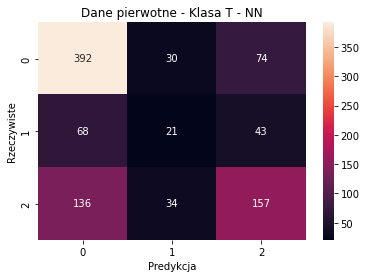

In [111]:

ax = plt.axes()
sns.heatmap(cf_matrix, annot=True, fmt='g')

ax.set_title('Dane pierwotne - Klasa T - NN')
plt.ylabel('Rzeczywiste')
plt.xlabel('Predykcja')
plt.show()


In [112]:
precision = precision_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'],  average='macro')
recall = recall_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'],  average='macro')
f1score=f1_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'], average='macro')
print('Recall: %.3f' % recall)
print('Precision: %.3f' % precision)
print('F1score: %.3f' % f1score)

Recall: 0.477
Precision: 0.493
F1score: 0.478


## dr. 01

In [90]:
cvscores

[0.39946012837547457,
 0.4590458453261094,
 0.5268597934535271,
 0.5028003613369466,
 0.2530650604468367]

In [91]:
sum(cvscores)/len(cvscores) #0.032977654217233775

0.4282462377877789

In [93]:
cf_matrix = confusion_matrix(dane_do_zapisu['obs'], dane_do_zapisu['pred'])

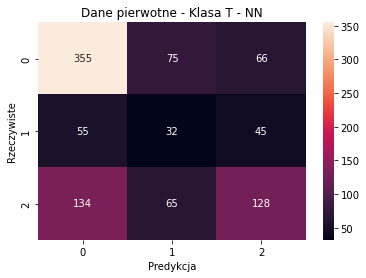

In [94]:

ax = plt.axes()
sns.heatmap(cf_matrix, annot=True, fmt='g')

ax.set_title('Dane pierwotne - Klasa T - NN')
plt.ylabel('Rzeczywiste')
plt.xlabel('Predykcja')
plt.show()


In [95]:
precision = precision_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'],  average='macro')
recall = recall_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'],  average='macro')
f1score=f1_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'], average='macro')
print('Recall: %.3f' % recall)
print('Precision: %.3f' % precision)
print('F1score: %.3f' % f1score)

Recall: 0.450
Precision: 0.458
F1score: 0.449


In [140]:
model.save('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/Modele sieci neuro')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

In [ ]:
df = pd.read_csv()